In this project we are dealing with a Customer Classification Problem from a company that wants to classify the customers into high-value customers and low-revenue customers, our aim to build a strong classifier which will segragate the customer based upon the given data.

In [1]:
## Importing the Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle ## helps storing the data into the pickle file

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split , StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
### Importing the Data

cwd = os.getcwd() ## getcwd() will give the path of current working directory

data_path = str(cwd) + '/Existing_Base.csv'

data = pd.read_csv(data_path) # Load the data

# data = pd.read_csv('Existing_Base.csv')

### Data Exploration

In [3]:
data.head()

REF_NO children age_band                status        occupation  \
0       1     Zero    51-55               Partner     Manual Worker   
1       2     Zero    55-60  Single/Never Married           Retired   
2       3     Zero    26-30  Single/Never Married      Professional   
3       5     Zero    18-21  Single/Never Married      Professional   
4       6     Zero    45-50               Partner  Business Manager   

  occupation_partner home_status      family_income self_employed  \
0  Secretarial/Admin    Own Home  <17,500, >=15,000            No   
1            Retired    Own Home  <27,500, >=25,000            No   
2              Other    Own Home  <30,000, >=27,500           Yes   
3      Manual Worker    Own Home  <15,000, >=12,500            No   
4            Unknown    Own Home  <30,000, >=27,500            No   

  self_employed_partner  ...  Investment Tax Saving Bond Home Loan  \
0                    No  ...                       19.99      0.00   
1                    No  ...                        0.00      0.00   
2                    No  ...                        0.00      3.49   
3                    No  ...                        0.00      0.00   
4                    No  ...                        0.00     45.91   

  Online Purchase Amount Revenue Grid  gender         region  \
0                   0.00            1  Female          Wales   
1                   0.00            2  Female     North West   
2                   0.00            2    Male          North   
3                   0.00            2  Female  West Midlands   
4                  25.98            2  Female       Scotland   

   Investment in Commudity  Investment in Equity  Investment in Derivative  \
0                    74.67                 18.66                     32.32   
1                    20.19                  0.00                      4.33   
2                    98.06                 31.07                     80.96   
3                     4.10                 14.15                     17.57   
4                    70.16                 55.86                     80.44   

   Portfolio Balance  
0              89.43  
1              22.78  
2             171.78  
3             -41.70  
4             235.02  

[5 rows x 32 columns]

In [4]:
## Here Target Variable is Revenue which has 2 class, '1' and '2'

In [5]:
data.shape

(10155, 32)

Data has 10155 rows and 32 features

In [6]:
# Checking the Data

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   REF_NO                           10155 non-null  int64  
 1   children                         10155 non-null  object 
 2   age_band                         10155 non-null  object 
 3   status                           10155 non-null  object 
 4   occupation                       10155 non-null  object 
 5   occupation_partner               10155 non-null  object 
 6   home_status                      10155 non-null  object 
 7   family_income                    10155 non-null  object 
 8   self_employed                    10155 non-null  object 
 9   self_employed_partner            10155 non-null  object 
 10  year_last_moved                  10155 non-null  int64  
 11  TVarea                           10155 non-null  object 
 12  post_code         

Insights
- Out of 32 columns, we have around 18 columns of numeric type, 14 columns of categorical type
- There doesn't seem to have missing values in the columns, however, we would investigate this once again
- Ref number can be dropped
- Remove the - and convert age_band into numeric... if there are not too many unique age_bands we may even create dummies.
- Remove the >< and convert the family_income into a numeric column.

In [7]:
### Checking for duplicate data if any

data.duplicated().sum()

0

- No Duplicate rows

In [8]:
# Distribution of Target Class ##

data['Revenue Grid'].value_counts()

Revenue Grid
2    9069
1    1086
Name: count, dtype: int64

- There is a class imbalance in my dataset. The model will be a biased learner as it will be more inclined toward learning the characteristic of class '2' or class with higher frequency and less towards to class with lower frequency.


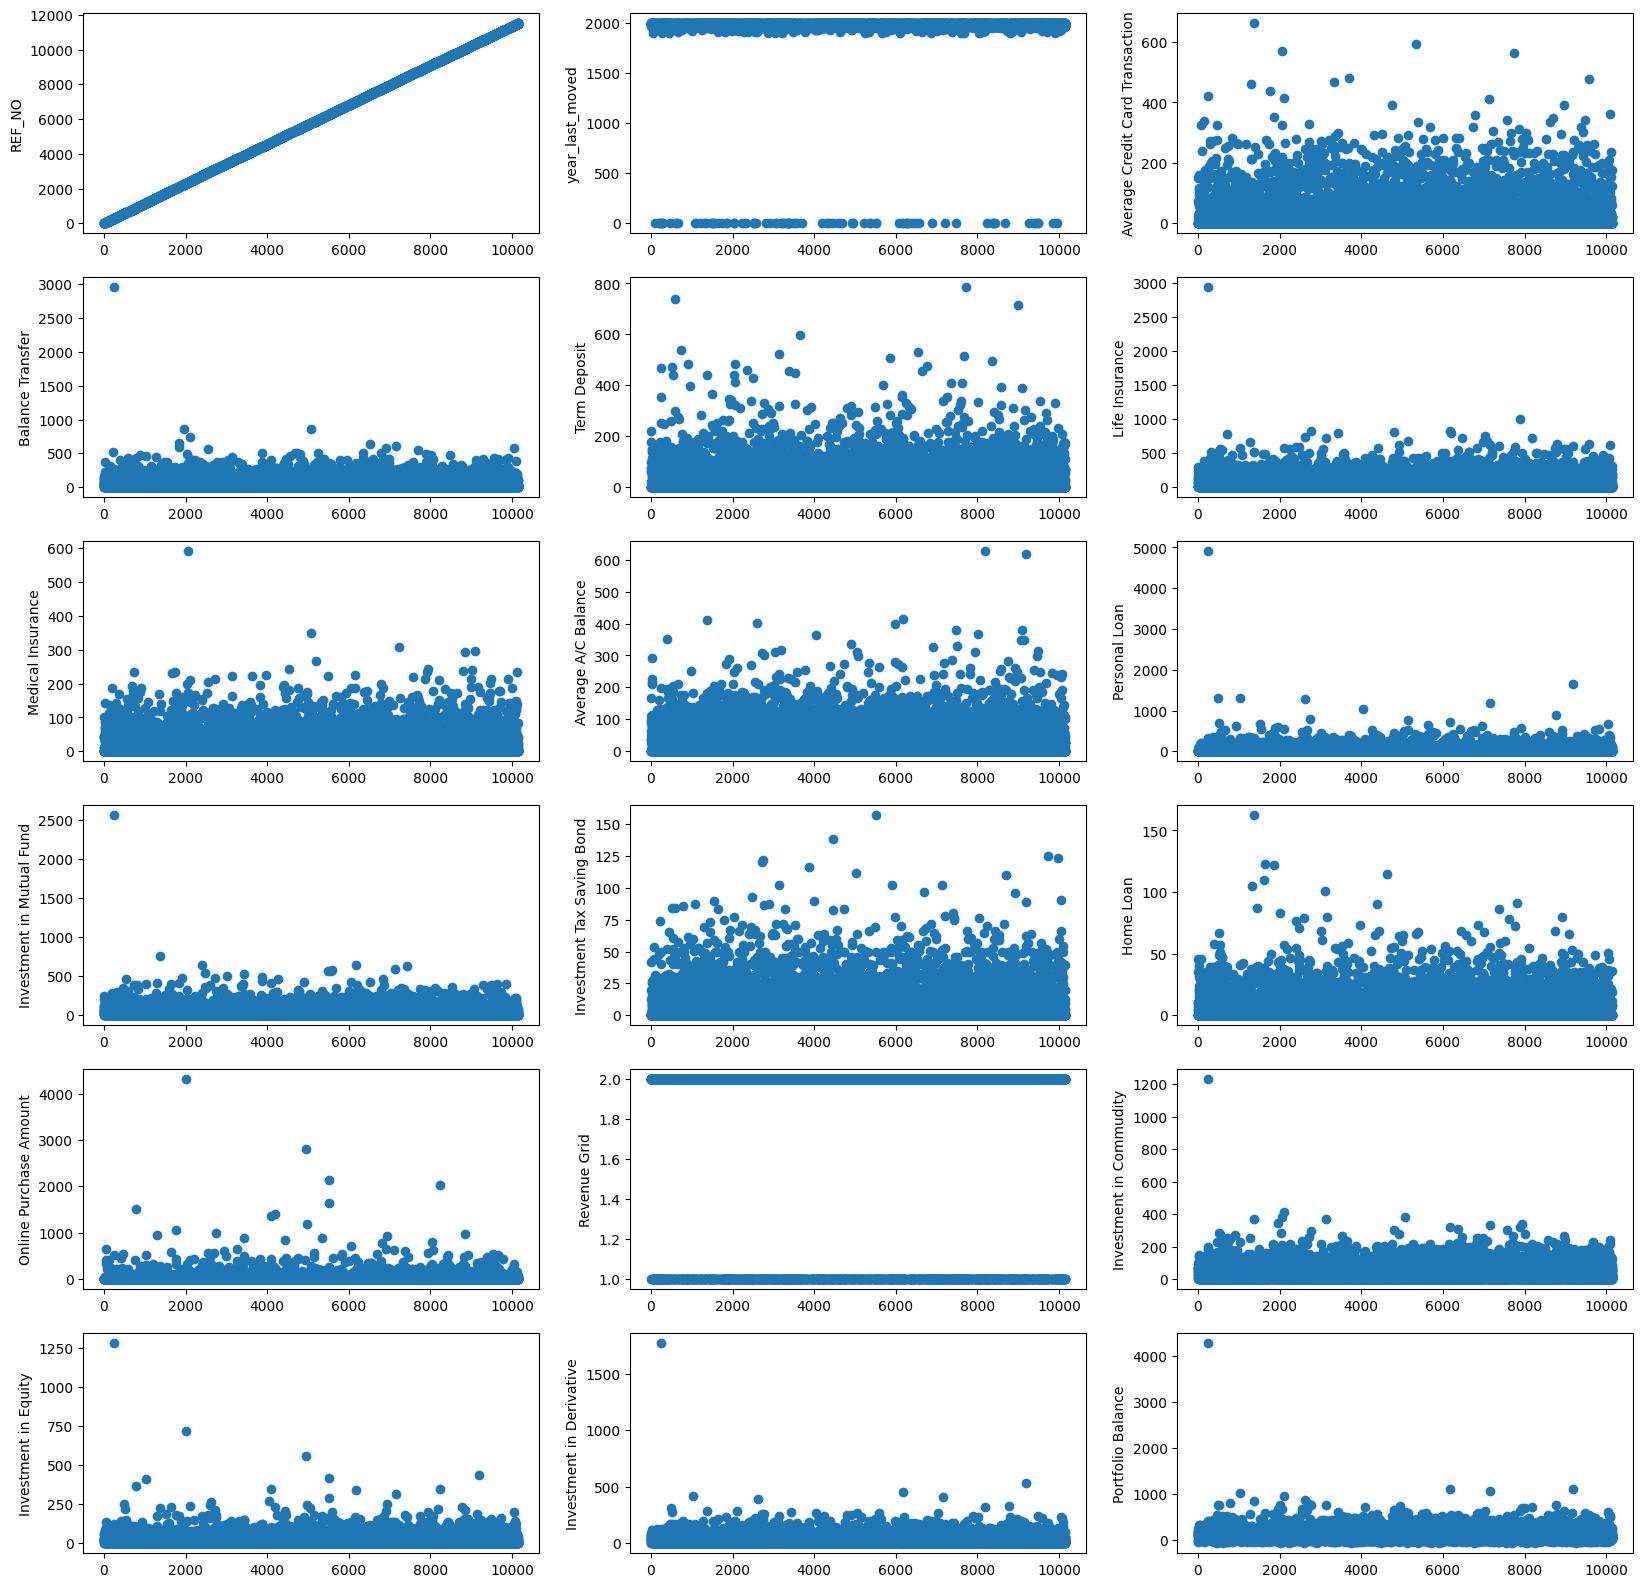

In [9]:
#### Visualizing Numeric columns ######


## To separate the numerical column we will use the func from pandas library .select_dtype(include =, exclude = )

## It has 2 arguments, include and exclude with None as default values, we need to pass the type of data_type which
## we want to select like for numercal we call pass int64, float64 and for categoriacal column we can pass 'object'
## int and float both are integers we will pass np.number which include both, we can pass, exclude = 'object'


num_col = data.select_dtypes(exclude='object') # num_col = data.select_dtypes(include= np.number)

col_name = list(num_col.columns) ## Creating a list of column names

## So we have 18 columns and we will try to plot then in frame of 6 rows and 3 columns using subplots

r = 6 # Row_Index
c = 3 # Col_Index

n = 0 # Flag to change the index

fig, axes = plt.subplots(nrows=r,ncols=c,figsize =(20,20))

for i in range(r):
    for j in range(c):
        axes[i][j].scatter(x = num_col.index, y = num_col[col_name[n]])
        axes[i][j].set_ylabel(col_name[n])
        n+=1

Insights:
- Ref Number column just contains the index so can be removed.
- year_last_moved column seem to have many values close to 0 or 0, these seem to be noise, investigate them.
- Average_credit_card_transaction,Balance Transfer seems to be highly right skewed, check if the skewness could be reduced.
- A single customer with very high value of balance transfer/life insurance etc stands out, this row could be
- considered outlier and be removed, row number 250
- Capping could be done to limit the impact of outliers.
- Scaling could be done since the scale is different for most of the variables.

In [10]:
# Checking outlier for 'Balance Transfer

a = data[data['Balance Transfer']>2500]

a['Personal Loan']

250    4905.93
Name: Personal Loan, dtype: float64

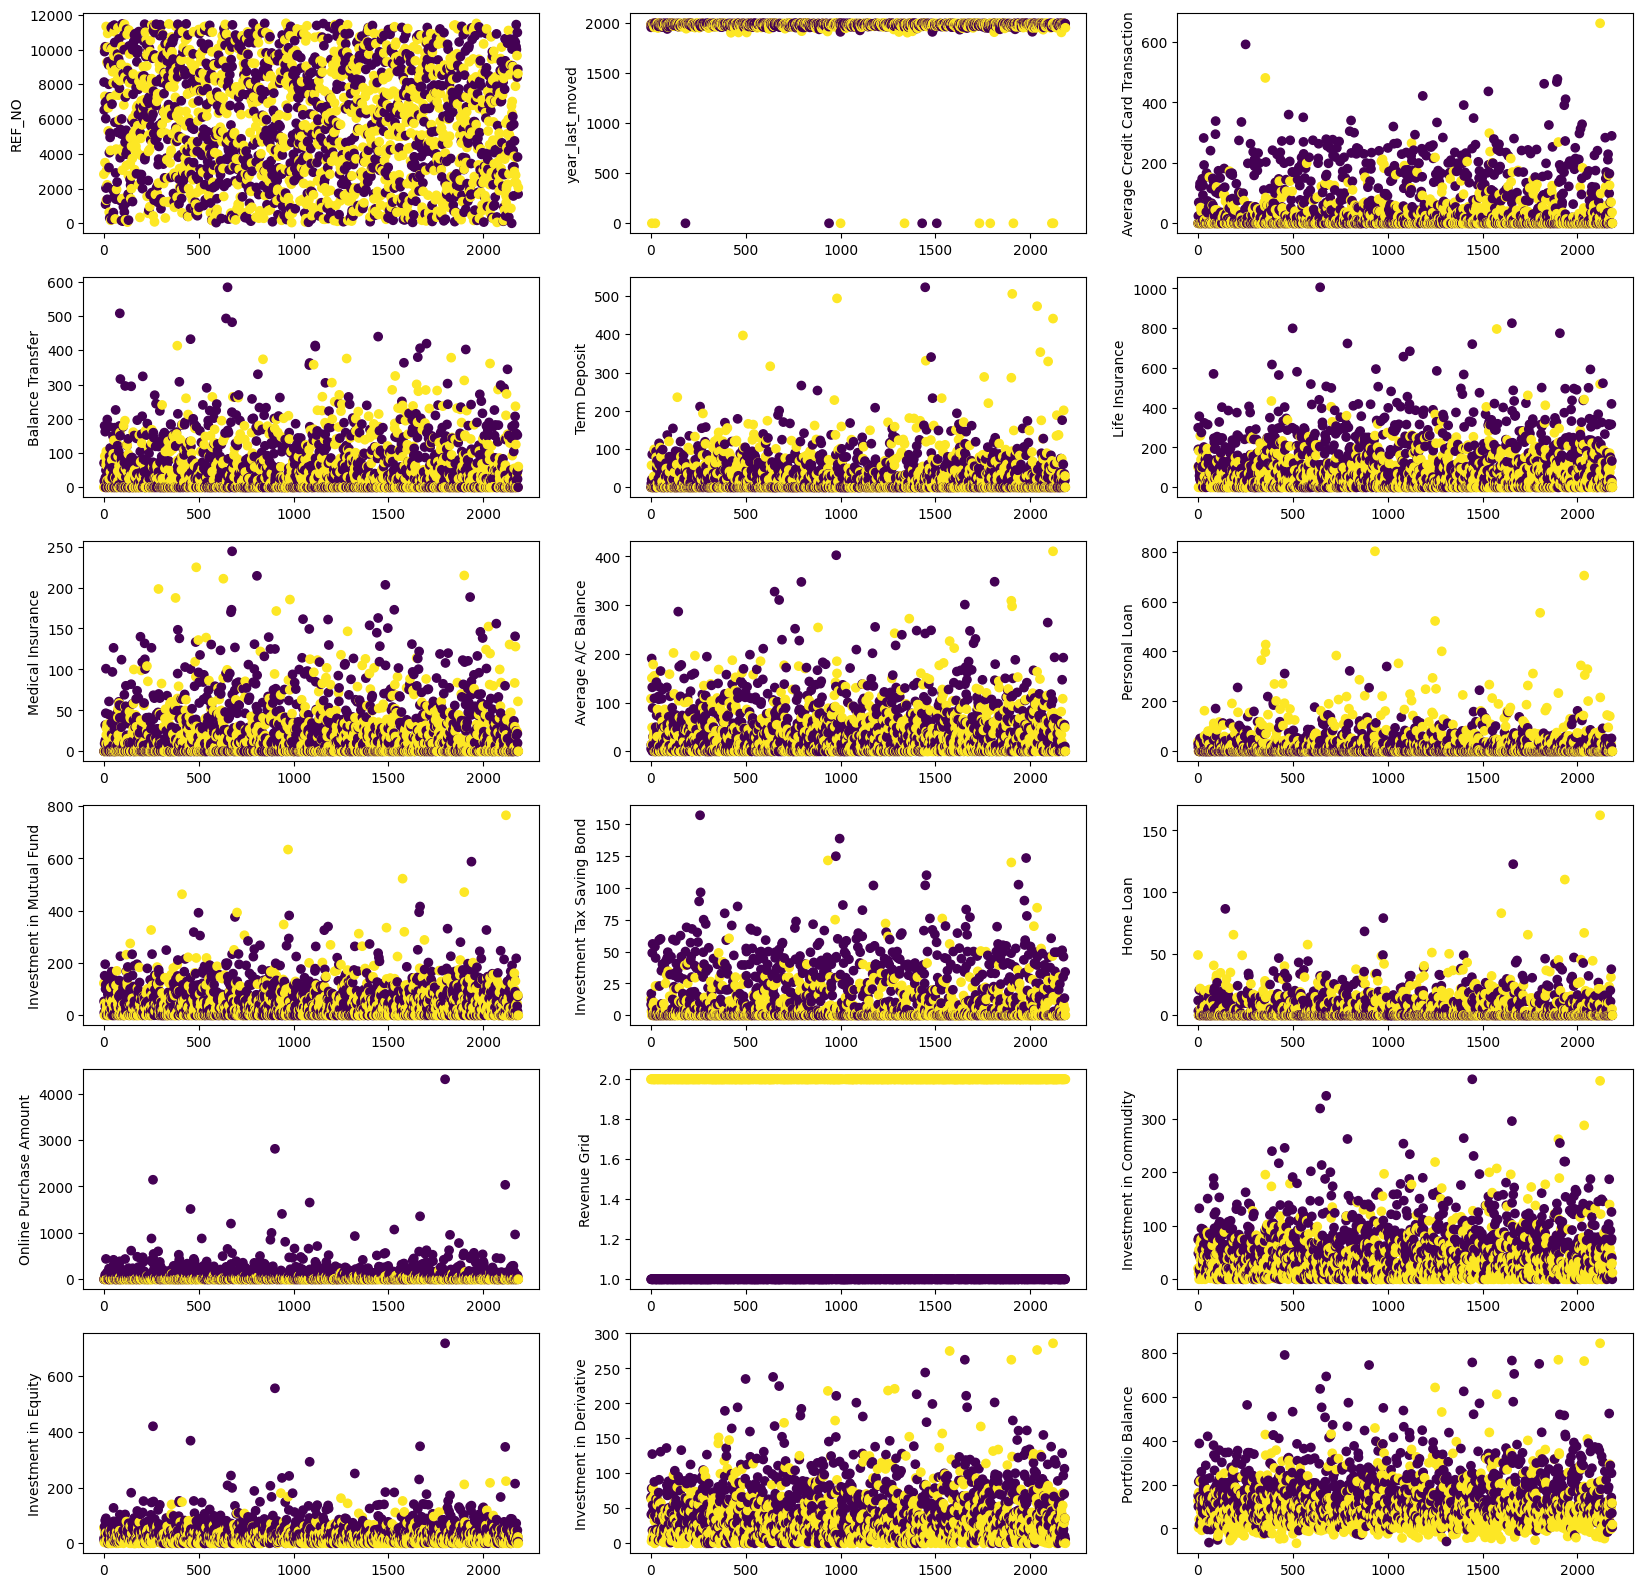

In [11]:
## Since there is a Imbalance in the Target Variable Classes 90%- Low Revenve (Class '2') and 10% are High Revenue
## Te have a better visulization , we will take a subset of the Class '2' with roughly 1100 customer and then
## concatinate with Class '1' and plot the number val col to have better visualisation.

num_data = data.select_dtypes(exclude='object')

low_rev = num_data[num_data['Revenue Grid']==2] ## Selecting low revenue
high_rev = num_data[num_data['Revenue Grid']==1] ## Selecting High revenue

lowrev = low_rev.sample(1100) ## Sampling 1100 low revenue


nw_df = pd.concat([lowrev, high_rev], axis = 0) ## Has Balanced Data

# Now the dataframe has been created in a way that all the first entries are of low revenue customer i.e class '2'
# followed by class '1' so make then randomly distuributed we use .sample to that they are randomly allocated
# not in order.

nw_df = nw_df.sample(frac=1) # To randomly suffle the dataframe

nw_df.reset_index(drop=True, inplace=True) # To reset the index again to 0

col_name = list(nw_df)

row_ind = 6
col_ind = 3

n1 = 0

fig, ax = plt.subplots(nrows= row_ind, ncols=col_ind, figsize=(20,20))

for i in range(row_ind):
    for j in range(col_ind):
        ax[i][j].scatter(y=nw_df[col_name[n1]], x = nw_df.index, c= nw_df['Revenue Grid'])
        ax[i][j].set_ylabel(col_name[n1])
        n1+=1

Insights:
- Yellow in Low Revenue and purple is High Revenue
- Ref_N0 - It is scattered across as they all are unique values
- Avergae Credit card Transactions = The plot is givng a very good idea that on an avg, High reveneuw customers are having high credit card transactions than the low revenuw customer. Mean of all the yellow points i.e low revenue customers are concentrated between 0 to 100 and Purple points are mainly concentracted about 100 and 300 so by looking at the ave CC transaction we can tell who is high revenue and who is low revenue customer as it is giving a very good segeration between two.
- Balance Transfer = It is also giving a good segeration between low and high revenue, For high revenue the points are slightly higher than yellow points. That mean low revenue points are on lower side.
- Life Insurance = It also gives very good seperation and similar to the Avg CC trasnsaction, its is showing that the High Revenue Customers has high value for Life Insurance as compare to low revenuw custimers.
- We can check the mean values of Low Revenue Customer in Life Insurance
- Online Purchase Amount = It is a very important feature and it is giving the very good seperation between the low revenue and high revenue customers as it very well seperating

In [12]:
# Checking the mean for 'Life Insurance' for Low Revenue Cust

nw_df['Life Insurance'][nw_df['Revenue Grid']==2].mean() ##  Mean for Low Revenue

58.89361818181819

In [13]:
# Checking the mean for 'Life Insurance' for Low Revenue Cust

nw_df['Life Insurance'][nw_df['Revenue Grid']==1].mean() ## Mean for High Revenue

125.90271639042358

- This shows that there is a well seperation between the Low and High Revenue customer in Life Insurance

In [14]:
## Feature 'year_last_moved' :-

# Checking for 0 value for the year.

(data['year_last_moved']==0).sum()

84

<Axes: xlabel='Revenue Grid', ylabel='year_last_moved'>

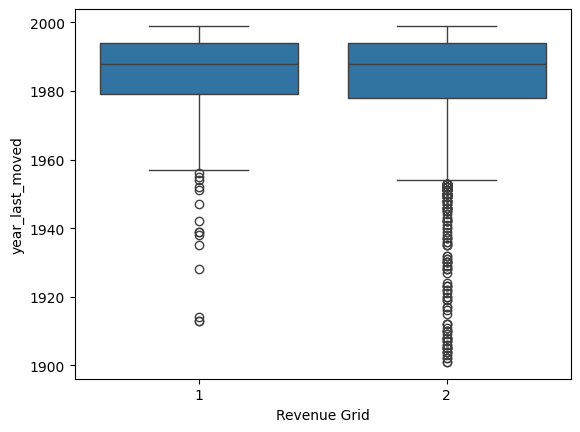

In [15]:
## Checking the Relation with Target variable using Box Plot

sns.boxplot(y = data['year_last_moved'][data['year_last_moved']>0], x=data['Revenue Grid']) # Box Plot

## Values are choose above 0 for the feature 'year_last_moved'


- So the feature 'year_last_moved' has 84 'Zero Values' for year which is a wrong value also the box plot of Low Revenue and High Revenue Customers are almost identical, Hence its is may be good estimator to predicting the High and Low Revenue Customer Hence we will decide to drop this feature in our First Iteration.

<Axes: xlabel='Investment in Commudity', ylabel='Density'>

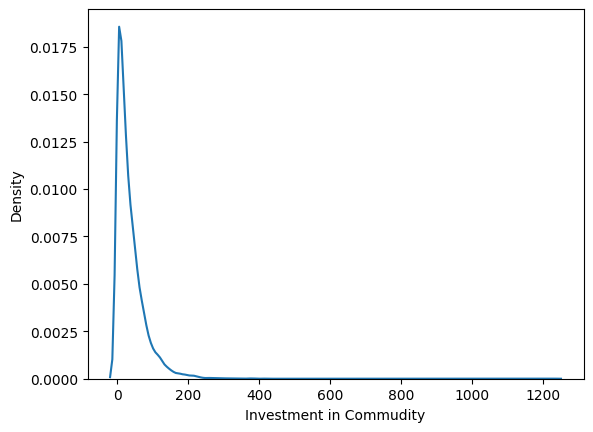

In [16]:
## Feature 'Investment in Commodity' using dist plot

sns.distplot(data['Investment in Commudity'], hist=False)

- Almost all the points are upto 200 after that there is no points at all.
- It is Right Skewed because 90% of the data is on Low Revenue customers side.
- It is expected due to imbalance in the class.

<Axes: xlabel='Revenue Grid', ylabel='Investment in Commudity'>

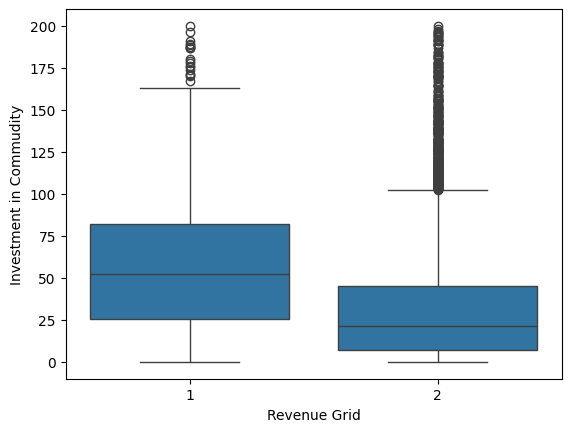

In [17]:
# Checking relation with Target Variable using Box Plot with values less than 200

sns.boxplot(y=data['Investment in Commudity'][data['Investment in Commudity']<200], x= data['Revenue Grid'])

- There is a descent segeration amount the High Revenue and Low Revenue customer hence this feature is good estimator for predicting the traget variable

<Axes: xlabel='Average Credit Card Transaction', ylabel='Density'>

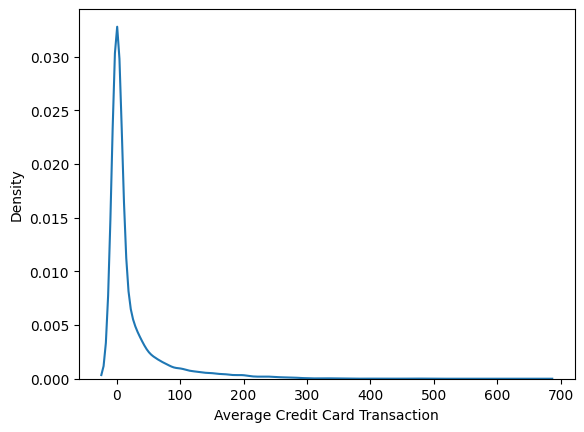

In [18]:
# Feature 'Average Credit Card Transaction' using dist plot

sns.distplot(data['Average Credit Card Transaction'], hist=False)

- It is a similar kind of distribution like Investment in comodity
- It is right skewed due to higher values on Low Revenue Customer side.
- So any variable that we plot will be baised towards the low revenue customer.

<Axes: xlabel='Revenue Grid', ylabel='Average Credit Card Transaction'>

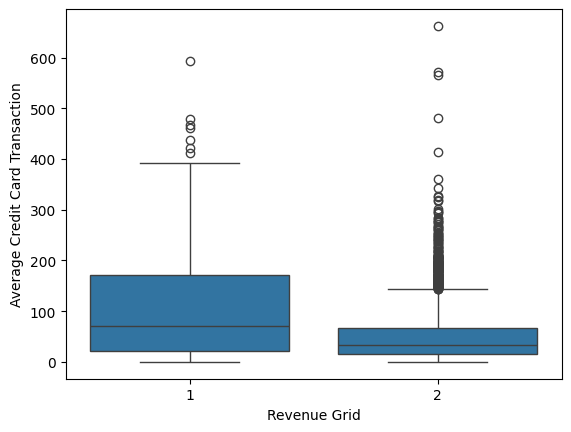

In [19]:
# Checking relation with Target Variable using Box Plot more than 0 for better understanding

sns.boxplot(y = data['Average Credit Card Transaction'][data['Average Credit Card Transaction']>0], x= data['Revenue Grid'])

- As rightly expected, the classes are well separated so this feature is also good estimator

<Axes: xlabel='Online Purchase Amount', ylabel='Density'>

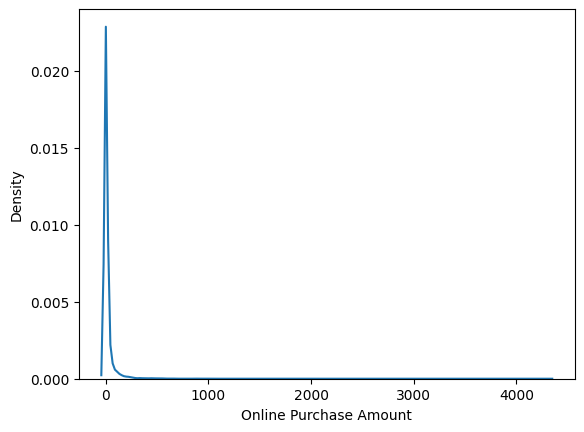

In [20]:
# Feature 'Online Purchase Amount' using dist plot

sns.distplot(data['Online Purchase Amount'], hist=False)

- Again its Rightly Skewed due to the Biasness of data toward Low Revenuw Customer.

<Axes: xlabel='Revenue Grid', ylabel='Online Purchase Amount'>

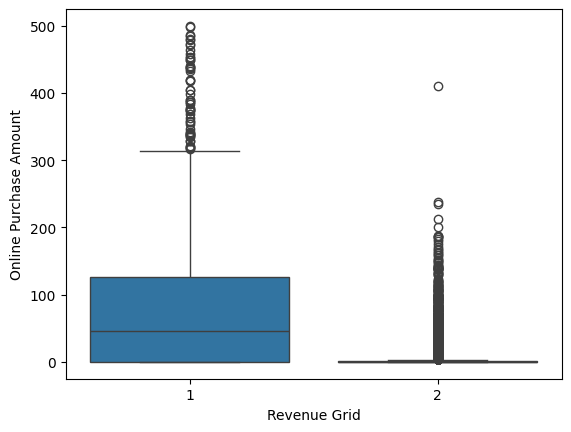

In [21]:
# Checking relation with Target Variable using Box Plot for less than 500

sns.boxplot(y= data['Online Purchase Amount'][data['Online Purchase Amount']<500], x = data['Revenue Grid'])

- Its is well seperated and good estimator for prediction.

<Axes: xlabel='Investment Tax Saving Bond', ylabel='Density'>

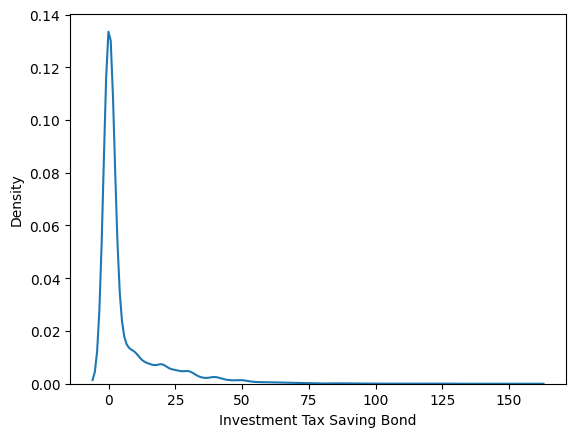

In [22]:
# Feature 'Investment Tax Saving Bond' using dist plot

sns.distplot(data['Investment Tax Saving Bond'], hist=False)


- Its is again Righly Skewed due to Biasness towards the Low Revenue

<Axes: xlabel='Revenue Grid', ylabel='Investment Tax Saving Bond'>

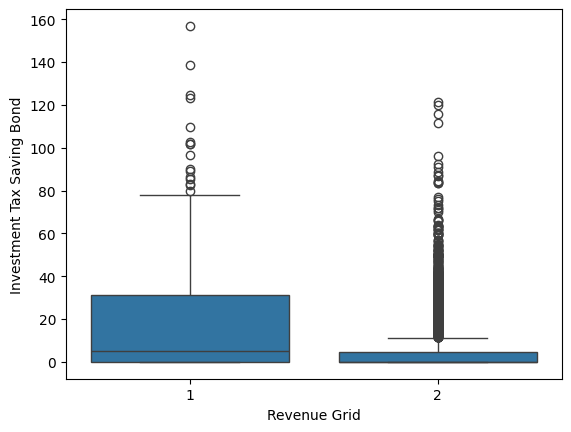

In [23]:
# Checking relation with Target Variable using Box Plot

sns.boxplot(y = data['Investment Tax Saving Bond'], x = data['Revenue Grid'])

- Here also the distribution is well seperated so its an good estimator for pridiction

<Axes: xlabel='Portfolio Balance', ylabel='Density'>

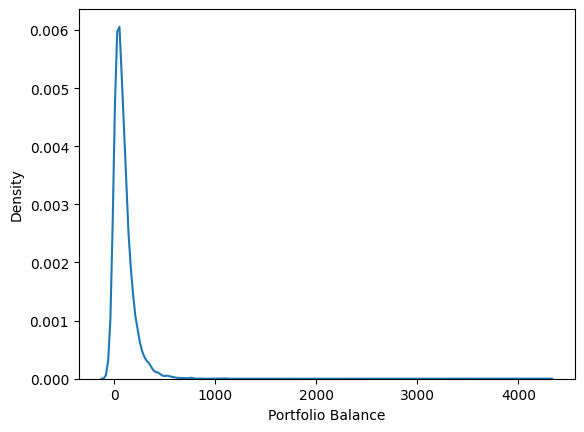

In [24]:
# Feature 'Postfolio Balance' using dist plot

sns.distplot(data['Portfolio Balance'], hist=False)


-  Rightly Skewed due to Biasness of data towards Low Revenue Class

<Axes: xlabel='Revenue Grid', ylabel='Portfolio Balance'>

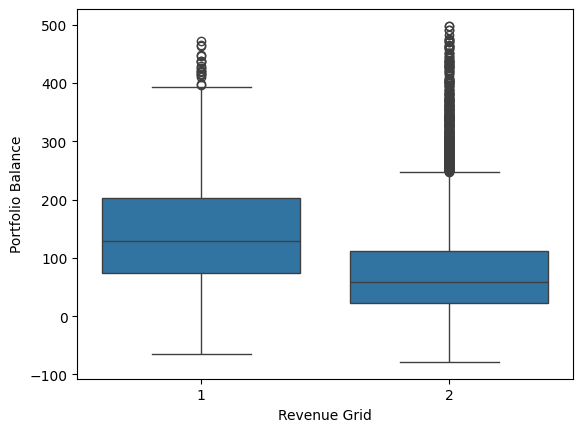

In [25]:
# Checking relation with Target Variable using Box Plot for less than 500 for better understanding

sns.boxplot(y= data['Portfolio Balance'][data['Portfolio Balance']<500], x = data['Revenue Grid'])

- Here also the distribution is well seperated so its an good estimator for pridiction

<Axes: xlabel='Investment in Equity', ylabel='Density'>

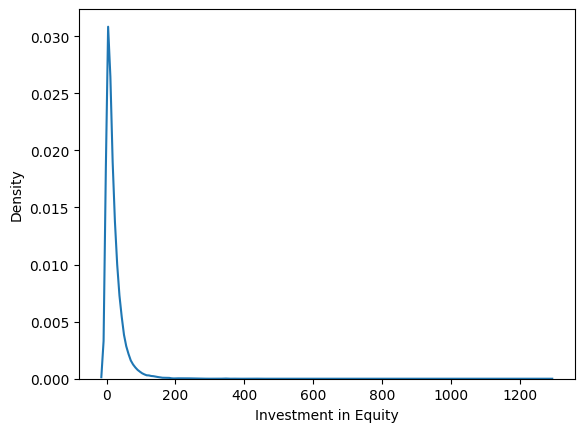

In [26]:
# Feature 'Investment In Equity' using dist plot

sns.distplot(data['Investment in Equity'], hist=False)

- Rightly Skewed due to Biasness of data towards Low Revenue Class

<Axes: xlabel='Revenue Grid', ylabel='Investment in Equity'>

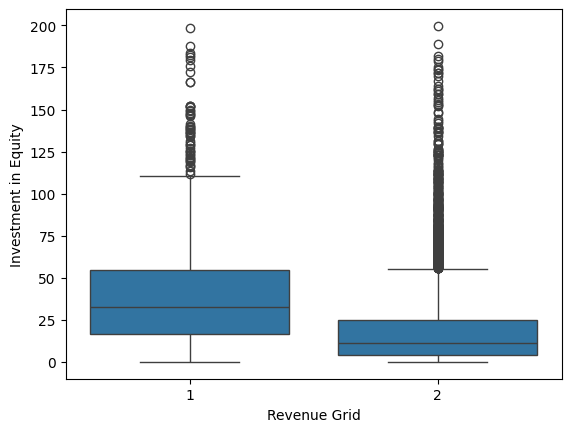

In [27]:
# Checking relation with Target Variable using Box Plot for less than 200 for better understanding

sns.boxplot(y=data['Investment in Equity'][data['Investment in Equity']<200], x = data['Revenue Grid'])


- Here also the distribution is well seperated so its an good estimator for pridiction

In [28]:
# Checking the correlation

## Desired state : We want features with low correlation amongst themselves and high correlation with
## the target columns

data.corr(numeric_only=True)

REF_NO  year_last_moved  \
REF_NO                           1.000000         0.028739   
year_last_moved                  0.028739         1.000000   
Average Credit Card Transaction -0.001217         0.014296   
Balance Transfer                -0.010711         0.013535   
Term Deposit                    -0.002313         0.004404   
Life Insurance                   0.008301         0.010689   
Medical Insurance                0.020776         0.015484   
Average A/C Balance             -0.005197         0.003031   
Personal Loan                   -0.010802         0.019718   
Investment in Mutual Fund       -0.006030         0.002569   
Investment Tax Saving Bond       0.000775         0.013158   
Home Loan                       -0.014010         0.003282   
Online Purchase Amount           0.003267        -0.005826   
Revenue Grid                    -0.010578        -0.018655   
Investment in Commudity          0.002082         0.016802   
Investment in Equity            -0.007154         0.008586   
Investment in Derivative        -0.000234         0.015582   
Portfolio Balance               -0.000721         0.017298   

                                 Average Credit Card Transaction  \
REF_NO                                                 -0.001217   
year_last_moved                                         0.014296   
Average Credit Card Transaction                         1.000000   
Balance Transfer                                        0.123855   
Term Deposit                                            0.323462   
Life Insurance                                          0.145041   
Medical Insurance                                       0.405090   
Average A/C Balance                                     0.172240   
Personal Loan                                           0.087289   
Investment in Mutual Fund                               0.150667   
Investment Tax Saving Bond                              0.133126   
Home Loan                                               0.087695   
Online Purchase Amount                                  0.132518   
Revenue Grid                                           -0.265197   
Investment in Commudity                                 0.497025   
Investment in Equity                                    0.205289   
Investment in Derivative                                0.228141   
Portfolio Balance                                       0.335674   

                                 Balance Transfer  Term Deposit  \
REF_NO                                  -0.010711     -0.002313   
year_last_moved                          0.013535      0.004404   
Average Credit Card Transaction          0.123855      0.323462   
Balance Transfer                         1.000000      0.229457   
Term Deposit                             0.229457      1.000000   
Life Insurance                           0.564538      0.274691   
Medical Insurance                        0.162085      0.506367   
Average A/C Balance                      0.358938      0.274027   
Personal Loan                            0.351499      0.146755   
Investment in Mutual Fund                0.454602      0.208948   
Investment Tax Saving Bond               0.166496      0.176975   
Home Loan                                0.153097      0.170584   
Online Purchase Amount                   0.112012      0.099455   
Revenue Grid                            -0.074756     -0.011817   
Investment in Commudity                  0.739791      0.620256   
Investment in Equity                     0.463556      0.266908   
Investment in Derivative                 0.581039      0.354304   
Portfolio Balance                        0.639400      0.454740   

                                 Life Insurance  Medical Insurance  \
REF_NO                                 0.008301           0.020776   
year_last_moved                        0.010689           0.015484   
Average Credit Card Transaction        0.145041           0.405090   
Balance T

<Axes: >

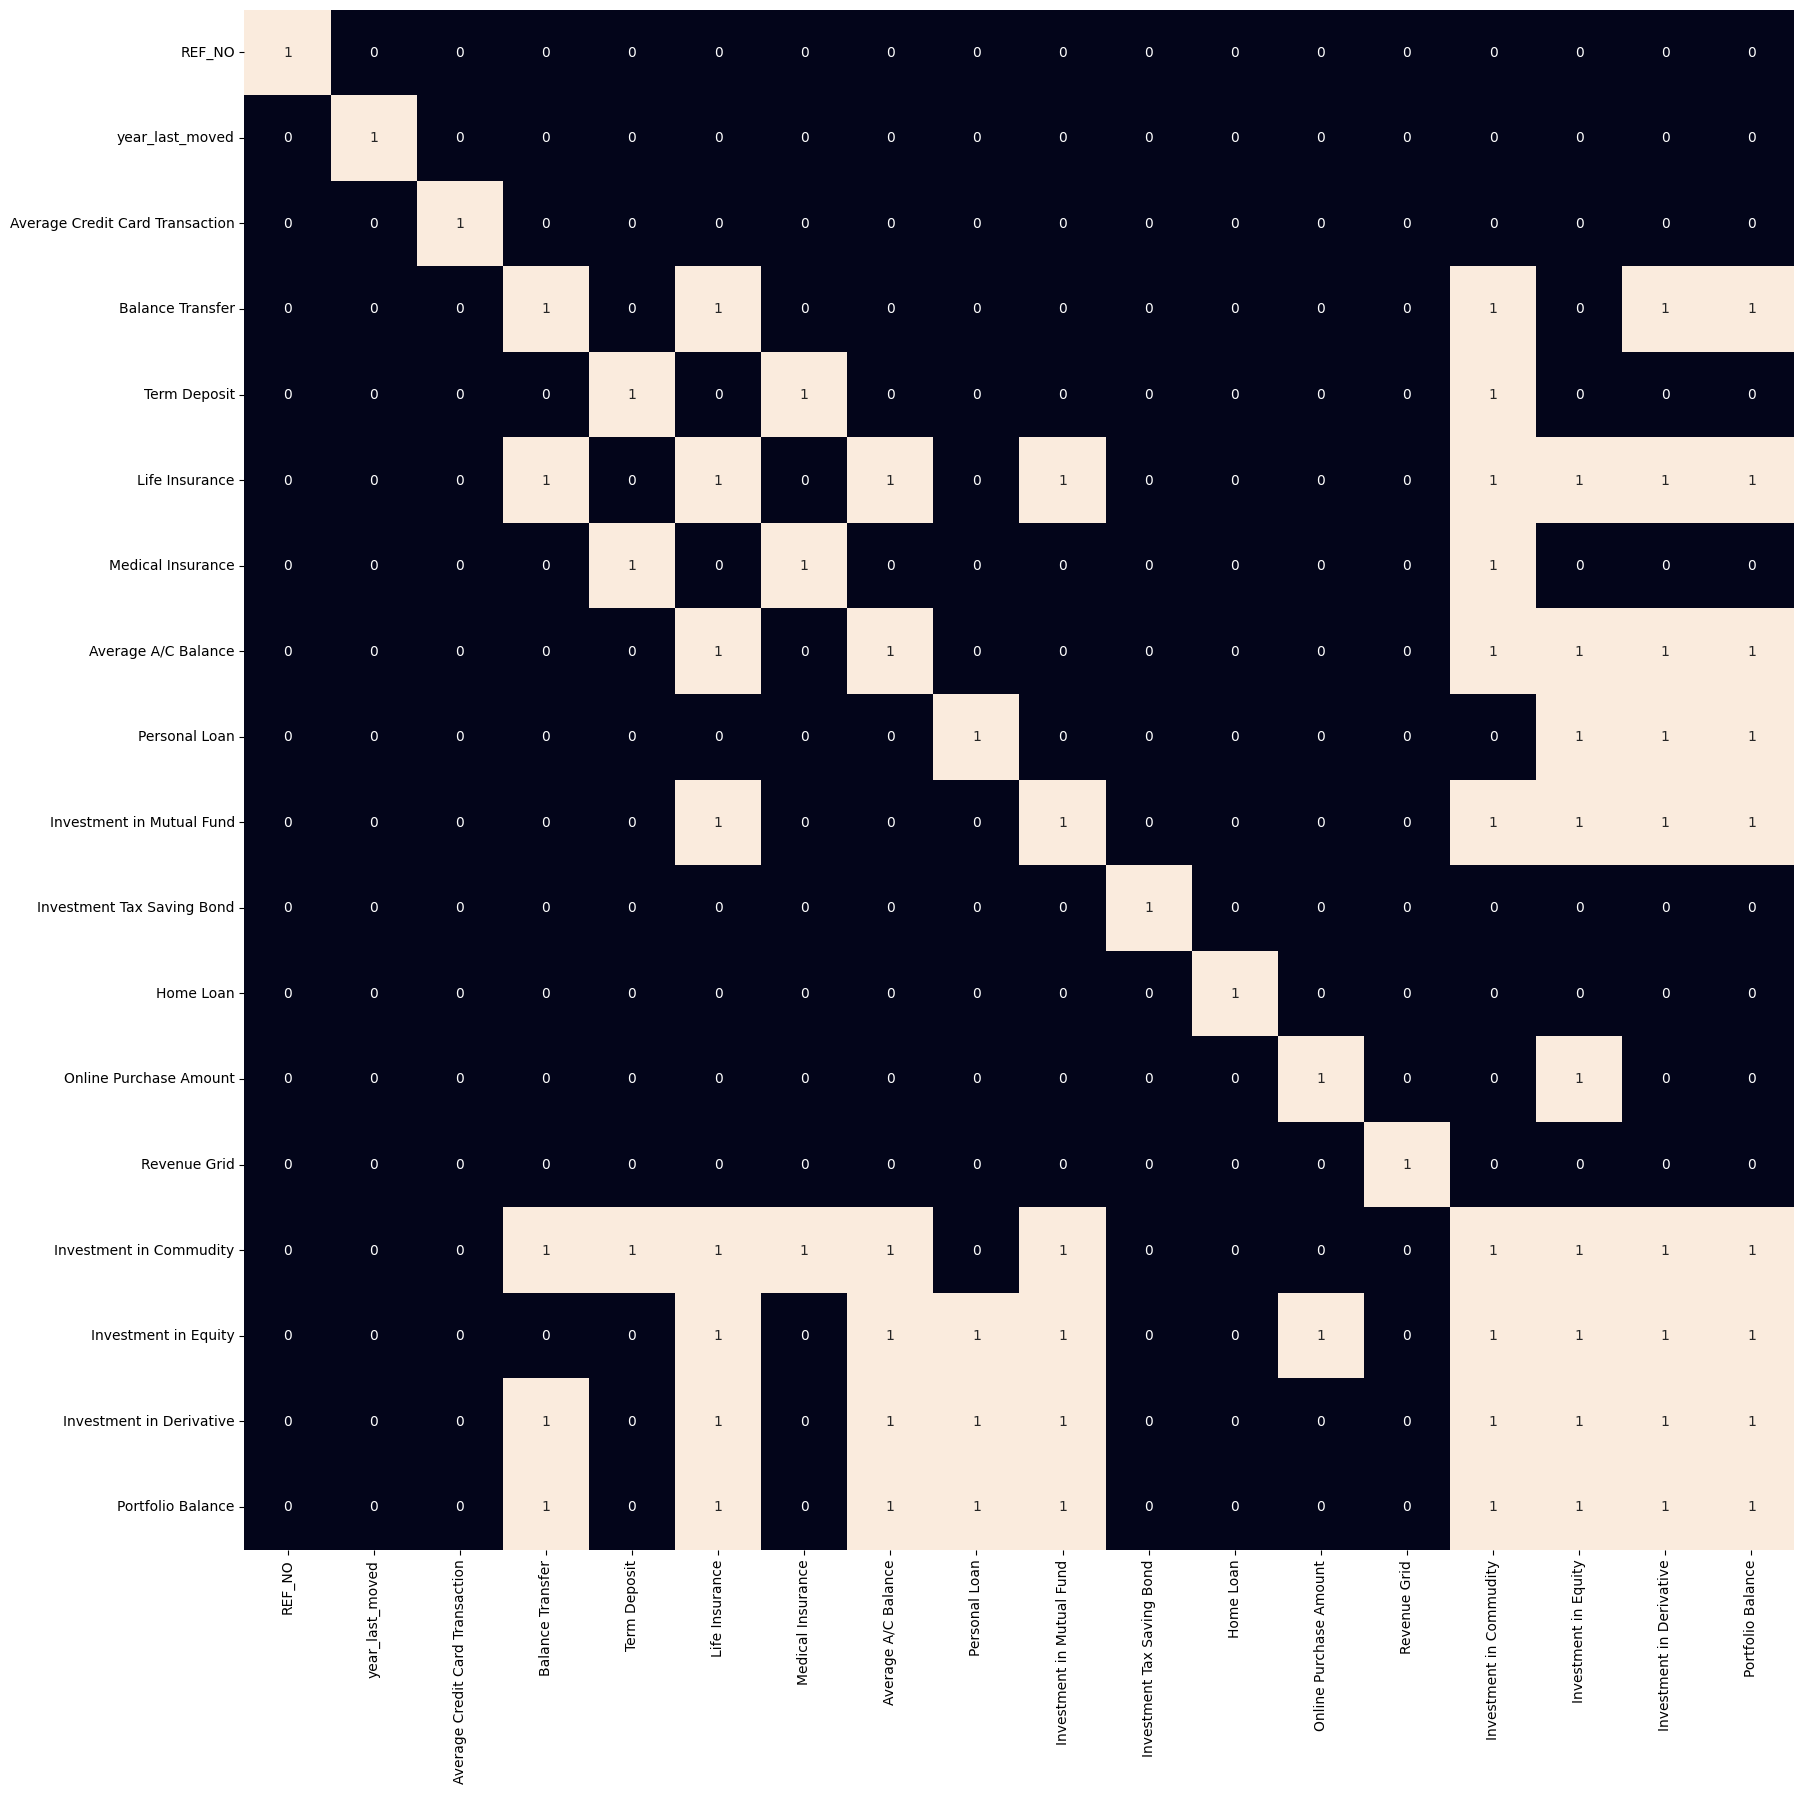

In [29]:
# Visualising Correlation Using Heatmap

plt.figure(figsize=(20,20))
sns.heatmap(((data.corr(numeric_only=True)>0.5)|(data.corr(numeric_only=True)<-0.5)), annot= True, cbar=False)

Note :Correlation Only measures the Linear dependencies / Linear Relation between the 2 variables.While working on Classification problem, variables/features tend to have Non-Linear Relations so if 2 variable has low co-relation that doesn't mean they are no related to each other.This simply means that they have weak Linear Relationship. So we will not make the decision based on correlarion

In [30]:
#### DECRIBING THE CATEGORICAL FEATURES / COLUMNS #####

## Again to seperate the categotical variables from the data, we will again use the .select_dtypes() function
## this time we will include all the features which are of object datatype.


cat_data = data.select_dtypes(include='object') # Subsetting the object datatype columns
column_names = list(cat_data.columns) ## Storing the column names

## Calculating the Unique Values of Each Categorical Feature

for i in column_names:
    print('Feature Name : ',i)
    print('No of Unique Elements : ',cat_data[i].nunique())
    print('\n*********\n')

###

Feature Name :  children
No of Unique Elements :  5

*********

Feature Name :  age_band
No of Unique Elements :  13

*********

Feature Name :  status
No of Unique Elements :  5

*********

Feature Name :  occupation
No of Unique Elements :  9

*********

Feature Name :  occupation_partner
No of Unique Elements :  9

*********

Feature Name :  home_status
No of Unique Elements :  5

*********

Feature Name :  family_income
No of Unique Elements :  13

*********

Feature Name :  self_employed
No of Unique Elements :  2

*********

Feature Name :  self_employed_partner
No of Unique Elements :  2

*********

Feature Name :  TVarea
No of Unique Elements :  14

*********

Feature Name :  post_code
No of Unique Elements :  10040

*********

Feature Name :  post_area
No of Unique Elements :  2039

*********

Feature Name :  gender
No of Unique Elements :  3

*********

Feature Name :  region
No of Unique Elements :  13

*********



Insights:
- post_code and post_area has too many unique values, converting them into onehot encoded vectors would blow up the dimensions.
- Currently we will remove the column and go ahead with the model.
- Similarly for post area.

In [31]:
## Anaylysing Categorical Features

cat_feature = data.select_dtypes(include='object')

cat_col = list(cat_feature.columns) ## storing catagorical features names

print(cat_col)

['children', 'age_band', 'status', 'occupation', 'occupation_partner', 'home_status', 'family_income', 'self_employed', 'self_employed_partner', 'TVarea', 'post_code', 'post_area', 'gender', 'region']


- So these are categorical features, lets try to understand the relationship with Target Variables
- To check the relationship between 2 categotical variable we will use crosstab() function from pandas library which gives the entries of each class in a particular feature w.r.t Target Variable class called as **Contingency** table



In [32]:
### Feature > 'age_band' relation with Revenue Grid

age_band_crosstab = pd.crosstab(index=data.age_band, columns=data['Revenue Grid'],margins=True)

## margin will give the total no. of entries

age_band_crosstab

Revenue Grid     1     2    All
age_band                       
18-21           11    52     63
22-25           50   406    456
26-30           99   828    927
31-35          112   949   1061
36-40          143   991   1134
41-45          123   989   1112
45-50          138  1221   1359
51-55          105   947   1052
55-60          120   927   1047
61-65           83   798    881
65-70           57   541    598
71+             42   368    410
Unknown          3    52     55
All           1086  9069  10155

Insight
- It should in the age_band 18-21, out of 63 entries, 11 are for High Revenuw and 52 are for Low revenue
- It is a dataframe


In [33]:
# lets add one more column, Precent High Revenue to it

age_band_crosstab['Precent High Revenue']= age_band_crosstab[1]/age_band_crosstab['All']*100
age_band_crosstab

Revenue Grid     1     2    All  Precent High Revenue
age_band                                             
18-21           11    52     63             17.460317
22-25           50   406    456             10.964912
26-30           99   828    927             10.679612
31-35          112   949   1061             10.556079
36-40          143   991   1134             12.610229
41-45          123   989   1112             11.061151
45-50          138  1221   1359             10.154525
51-55          105   947   1052              9.980989
55-60          120   927   1047             11.461318
61-65           83   798    881              9.421112
65-70           57   541    598              9.531773
71+             42   368    410             10.243902
Unknown          3    52     55              5.454545
All           1086  9069  10155             10.694239

- As per observation we see a variation of High Revenue Customer Class at different age bands hence its a good estimator for predition.

In [34]:
## Feature >> 'status'

print(data.status.value_counts())
status_crosstab = pd.crosstab(index=data.status, columns=data['Revenue Grid'], margins=True)
status_crosstab['Precent High Revenue'] = status_crosstab[1]/status_crosstab['All']*100
status_crosstab

status
Partner                 7709
Single/Never Married    1101
Divorced/Separated       679
Widowed                  618
Unknown                   48
Name: count, dtype: int64


Revenue Grid             1     2    All  Precent High Revenue
status                                                       
Divorced/Separated      73   606    679             10.751105
Partner                838  6871   7709             10.870411
Single/Never Married   117   984   1101             10.626703
Unknown                  3    45     48              6.250000
Widowed                 55   563    618              8.899676
All                   1086  9069  10155             10.694239

- Looking at the Percent High Revenue, it is found that mostly classes of 'status' share similar % w.r.t High Revenue Customer that mean if someone ask if a customer belongs to class 1 which is that status of the customer then we cannot estimate properly if the person is Divorced/seperated, or Partner or Single as all share 10% approx proportion of Class '1' of Target Variable, hence its not a good estimator of Target Variable, However we wil still keep it.

In [35]:
## Feature : 'occupation'

print(data.occupation.value_counts())

occ_crosstab= pd.crosstab(index=data.occupation, columns=data['Revenue Grid'], margins=True)

occ_crosstab['Percent High Revenue'] = occ_crosstab[1]/occ_crosstab['All']*100

occ_crosstab

occupation
Professional         2449
Retired              2206
Secretarial/Admin    1797
Housewife            1255
Business Manager      732
Unknown               567
Manual Worker         556
Other                 537
Student                56
Name: count, dtype: int64


Revenue Grid          1     2    All  Percent High Revenue
occupation                                                
Business Manager     85   647    732             11.612022
Housewife           117  1138   1255              9.322709
Manual Worker        63   493    556             11.330935
Other                61   476    537             11.359404
Professional        282  2167   2449             11.514904
Retired             220  1986   2206              9.972801
Secretarial/Admin   189  1608   1797             10.517529
Student               6    50     56             10.714286
Unknown              63   504    567             11.111111
All                1086  9069  10155             10.694239

 - Values Varies between 9 to 11% , and partillay estimator of Target Variables as 5 classes has 11%, we decide to keep them in first iteration.

In [36]:
## Feature 'occupation partner'

print(data.occupation_partner.value_counts())

occ_par_crosstab = pd.crosstab(index=data.occupation_partner, columns=data['Revenue Grid'], margins= True)
occ_par_crosstab['Precent High Revenue']= occ_par_crosstab[1]/occ_par_crosstab['All']*100

occ_par_crosstab

occupation_partner
Unknown              2394
Professional         2051
Retired              1936
Manual Worker        1508
Business Manager      737
Secretarial/Admin     662
Housewife             527
Other                 324
Student                16
Name: count, dtype: int64


Revenue Grid           1     2    All  Precent High Revenue
occupation_partner                                         
Business Manager      81   656    737             10.990502
Housewife             56   471    527             10.626186
Manual Worker        165  1343   1508             10.941645
Other                 33   291    324             10.185185
Professional         234  1817   2051             11.409069
Retired              189  1747   1936              9.762397
Secretarial/Admin     80   582    662             12.084592
Student                2    14     16             12.500000
Unknown              246  2148   2394             10.275689
All                 1086  9069  10155             10.694239

- Again the values lies between 9.7% to 12%. This gives the good segregation of categories and can be useful to estimate the prediction

In [37]:
## Feature > 'home_status'

print(data.home_status.value_counts())

home_crosstab = pd.crosstab(index=data.home_status, columns=data['Revenue Grid'], margins=True)

home_crosstab['Percent High Revenue']= home_crosstab[1]/home_crosstab['All']*100

home_crosstab

home_status
Own Home                9413
Rent from Council/HA     322
Rent Privately           261
Live in Parental Hom     109
Unclassified              50
Name: count, dtype: int64


Revenue Grid             1     2    All  Percent High Revenue
home_status                                                  
Live in Parental Hom    12    97    109             11.009174
Own Home              1004  8409   9413             10.666100
Rent Privately          28   233    261             10.727969
Rent from Council/HA    38   284    322             11.801242
Unclassified             4    46     50              8.000000
All                   1086  9069  10155             10.694239

- Overall a good estimator for predicting the Target variable classes

In [38]:
## Feature > 'family_income'

print(data.family_income.value_counts())

f_crosstab = pd.crosstab(index=data.family_income, columns= data['Revenue Grid'], margins=True)

f_crosstab['Percent High Revenue']= f_crosstab[1]/f_crosstab['All']*100

f_crosstab

family_income
>=35,000             2517
<27,500, >=25,000    1227
<30,000, >=27,500     994
<25,000, >=22,500     833
<20,000, >=17,500     683
<12,500, >=10,000     677
<17,500, >=15,000     634
<15,000, >=12,500     629
<22,500, >=20,000     590
<10,000, >= 8,000     563
< 8,000, >= 4,000     402
< 4,000               278
Unknown               128
Name: count, dtype: int64


Revenue Grid          1     2    All  Percent High Revenue
family_income                                             
< 4,000              21   257    278              7.553957
< 8,000, >= 4,000    32   370    402              7.960199
<10,000, >= 8,000    60   503    563             10.657194
<12,500, >=10,000    69   608    677             10.192024
<15,000, >=12,500    70   559    629             11.128776
<17,500, >=15,000    78   556    634             12.302839
<20,000, >=17,500    76   607    683             11.127379
<22,500, >=20,000    70   520    590             11.864407
<25,000, >=22,500    86   747    833             10.324130
<27,500, >=25,000   119  1108   1227              9.698452
<30,000, >=27,500   115   879    994             11.569416
>=35,000            281  2236   2517             11.164084
Unknown               9   119    128              7.031250
All                1086  9069  10155             10.694239

- Different classes give the different values ranging from 7% to 12.3% so good estimator for prediction.

In [39]:
## Feature > 'self_employed'

print(data.self_employed.value_counts())

se_crosstab = pd.crosstab(index=data.self_employed, columns=data['Revenue Grid'],margins= True)

se_crosstab['Percent High Revenue']= se_crosstab[1]/se_crosstab['All']*100

se_crosstab

self_employed
No     9436
Yes     719
Name: count, dtype: int64


Revenue Grid      1     2    All  Percent High Revenue
self_employed                                         
No             1001  8435   9436             10.608309
Yes              85   634    719             11.821975
All            1086  9069  10155             10.694239

- Only 2 classes and give 10.6 to 11.8% Hence could be good estimator for predictions.

In [40]:
## Feature > 'self_employed_partner'

print(data.self_employed_partner.value_counts())

self_crosstab = pd.crosstab(index=data.self_employed_partner, columns=data['Revenue Grid'],margins= True)

self_crosstab['Percent High Revenue']= self_crosstab[1]/self_crosstab['All']*100

self_crosstab

self_employed_partner
No     9026
Yes    1129
Name: count, dtype: int64


Revenue Grid              1     2    All  Percent High Revenue
self_employed_partner                                         
No                      957  8069   9026             10.602703
Yes                     129  1000   1129             11.426041
All                    1086  9069  10155             10.694239

- Only 2 classes and give 10.6 to 11.4% Hence could be good estimator for predictions

In [41]:
## Feature > 'TVarea'

print(data.TVarea.value_counts())

tv_crosstab = pd.crosstab(index=data.TVarea, columns=data['Revenue Grid'],margins= True)

tv_crosstab['Percent High Revenue']= tv_crosstab[1]/tv_crosstab['All']*100

tv_crosstab

TVarea
Central          1618
Carlton          1541
Meridian         1226
Yorkshire        1042
Granada          1039
HTV               845
Anglia            751
Tyne Tees         536
Scottish TV       520
TV South West     363
Grampian          227
Unknown           189
Ulster            159
Border             99
Name: count, dtype: int64


Revenue Grid      1     2    All  Percent High Revenue
TVarea                                                
Anglia           83   668    751             11.051931
Border           14    85     99             14.141414
Carlton         168  1373   1541             10.902012
Central         184  1434   1618             11.372064
Grampian         22   205    227              9.691630
Granada         121   918   1039             11.645813
HTV              82   763    845              9.704142
Meridian        112  1114   1226              9.135400
Scottish TV      56   464    520             10.769231
TV South West    33   330    363              9.090909
Tyne Tees        50   486    536              9.328358
Ulster           19   140    159             11.949686
Unknown          22   167    189             11.640212
Yorkshire       120   922   1042             11.516315
All            1086  9069  10155             10.694239

- Different classes with values ranging between 9.09 to 14.14%, could be a good estimator

In [42]:
## Feature > 'gender'

print(data.gender.value_counts())

gen_crosstab = pd.crosstab(index=data.gender, columns=data['Revenue Grid'],margins= True)

gen_crosstab['Percent High Revenue']= gen_crosstab[1]/gen_crosstab['All']*100

gen_crosstab

gender
Female     7634
Male       2486
Unknown      35
Name: count, dtype: int64


Revenue Grid     1     2    All  Percent High Revenue
gender                                               
Female         796  6838   7634             10.427037
Male           282  2204   2486             11.343524
Unknown          8    27     35             22.857143
All           1086  9069  10155             10.694239

- Only 2 classes and give 10.6 to 11.4% Hence could be good estimator for predictions

In [43]:
## Feature > 'region'

print(data.region.value_counts())

reg_crosstab = pd.crosstab(index=data.region, columns=data['Revenue Grid'],margins= True)

reg_crosstab['Percent High Revenue']= reg_crosstab[1]/reg_crosstab['All']*100

reg_crosstab

region
South East          2100
North West          1896
Unknown             1080
South West           971
West Midlands        820
Scotland             787
East Midlands        771
North                571
Wales                556
East Anglia          423
Northern Ireland     159
Isle of Man           16
Channel Islands        5
Name: count, dtype: int64


Revenue Grid         1     2    All  Percent High Revenue
region                                                   
Channel Islands      1     4      5             20.000000
East Anglia         56   367    423             13.238771
East Midlands       80   691    771             10.376135
Isle of Man          0    16     16              0.000000
North               55   516    571              9.632224
North West         201  1695   1896             10.601266
Northern Ireland    19   140    159             11.949686
Scotland            83   704    787             10.546379
South East         219  1881   2100             10.428571
South West          89   882    971              9.165808
Unknown            128   952   1080             11.851852
Wales               61   495    556             10.971223
West Midlands       94   726    820             11.463415
All               1086  9069  10155             10.694239

- Different Regions giving values ranging 9.16 to 20% hence it could be good estimator.
- post_code', 'post_area' has not much relation and has highest unique values hence we will drop them in our first iteration.

### Data Prepocessing

In [44]:
print('The Shape of the Dataframe Before Preprocessing : ', data.shape)

The Shape of the Dataframe Before Preprocessing :  (10155, 32)


In [45]:
## Preprocess - 1: Remove the customer data which has unusually high values for multiple features

## First we have to remove that customer whose life insurance value is more than 2500 as it has been an outlier
## for other features too

data = data[data['Life Insurance']<2500] ## Dropping the customer with unusually high feature values

print('The Shape of the Dataframe After First Preprocessing Block : ',data.shape)
## Rows reduced to 10154 from 10155

The Shape of the Dataframe After First Preprocessing Block :  (10154, 32)


In [46]:
## Preprocess - 2: Remove the REF_NO and year_last_moved

## year_last_moved has 84 values of 0 for a year, which is a tricky column to deal with as the box plot for
## High and low revenue customers are also similar which is not a good estimator for predicts hence we are dropping
## the column in the First Iteration of Preprocessing

removed_col =[] # List to store the names of removed column

data.drop(['REF_NO', 'year_last_moved'], axis =1, inplace=True)

removed_col.append('REF_NO')
removed_col.append('year_last_moved')
print('The Shape of the Dataframe After Second Preprocessing Block : ', data.shape) # checking the new shape and removed column list

The Shape of the Dataframe After Second Preprocessing Block :  (10154, 30)


In [47]:
## Preprocess - 3: Remove the post_code and post_area

## post_code and post_area have too many unique values, converting them into one hot encoded vector would blow up
## the dimensions.
## Currently we will remove the column and go ahead with the model

data.drop(['post_code','post_area'], axis =1, inplace=True) ## Dropping the columns
removed_col.append('post_code')
removed_col.append('post_aread') ## Storing column name in list

print('The Shape of the Dataframe After Third Preprocessing Block : ',data.shape) # checking the new shape and removed column list

The Shape of the Dataframe After Third Preprocessing Block :  (10154, 28)


In [48]:
#### OUTLIER TREATMENT #####

## There are usually 2 ways of treating the outlier,
## 1. Drop the record: It is the last option that we do due avoid data loss
## 2. CAPPING: It is the process of capping the values into the confined range that any value that is above and below
## The range will be assigned the border values. Usually, 99th percentile and 1st percentile are followed
## However it is always preferred to do individual capping rather do blanket capping or to go for camping once
## Go to avoid changing more data points or to change the values for those features which doesn't require outlier
## treatment or doesn't have any outliers.



## Since in the First Block of preprocessing we have dropped that one record that has unusually high values for
## many features.
## Now we will try to visualize the Numerical plots again to visualize the outlier and then we will treat them.

### Again Visualizing the Numerical Variables to Observe the Outliers

num_col1 = data.select_dtypes(exclude='object') # num_col = data.select_dtypes(include= np.number)

num_col1.shape

(10154, 16)

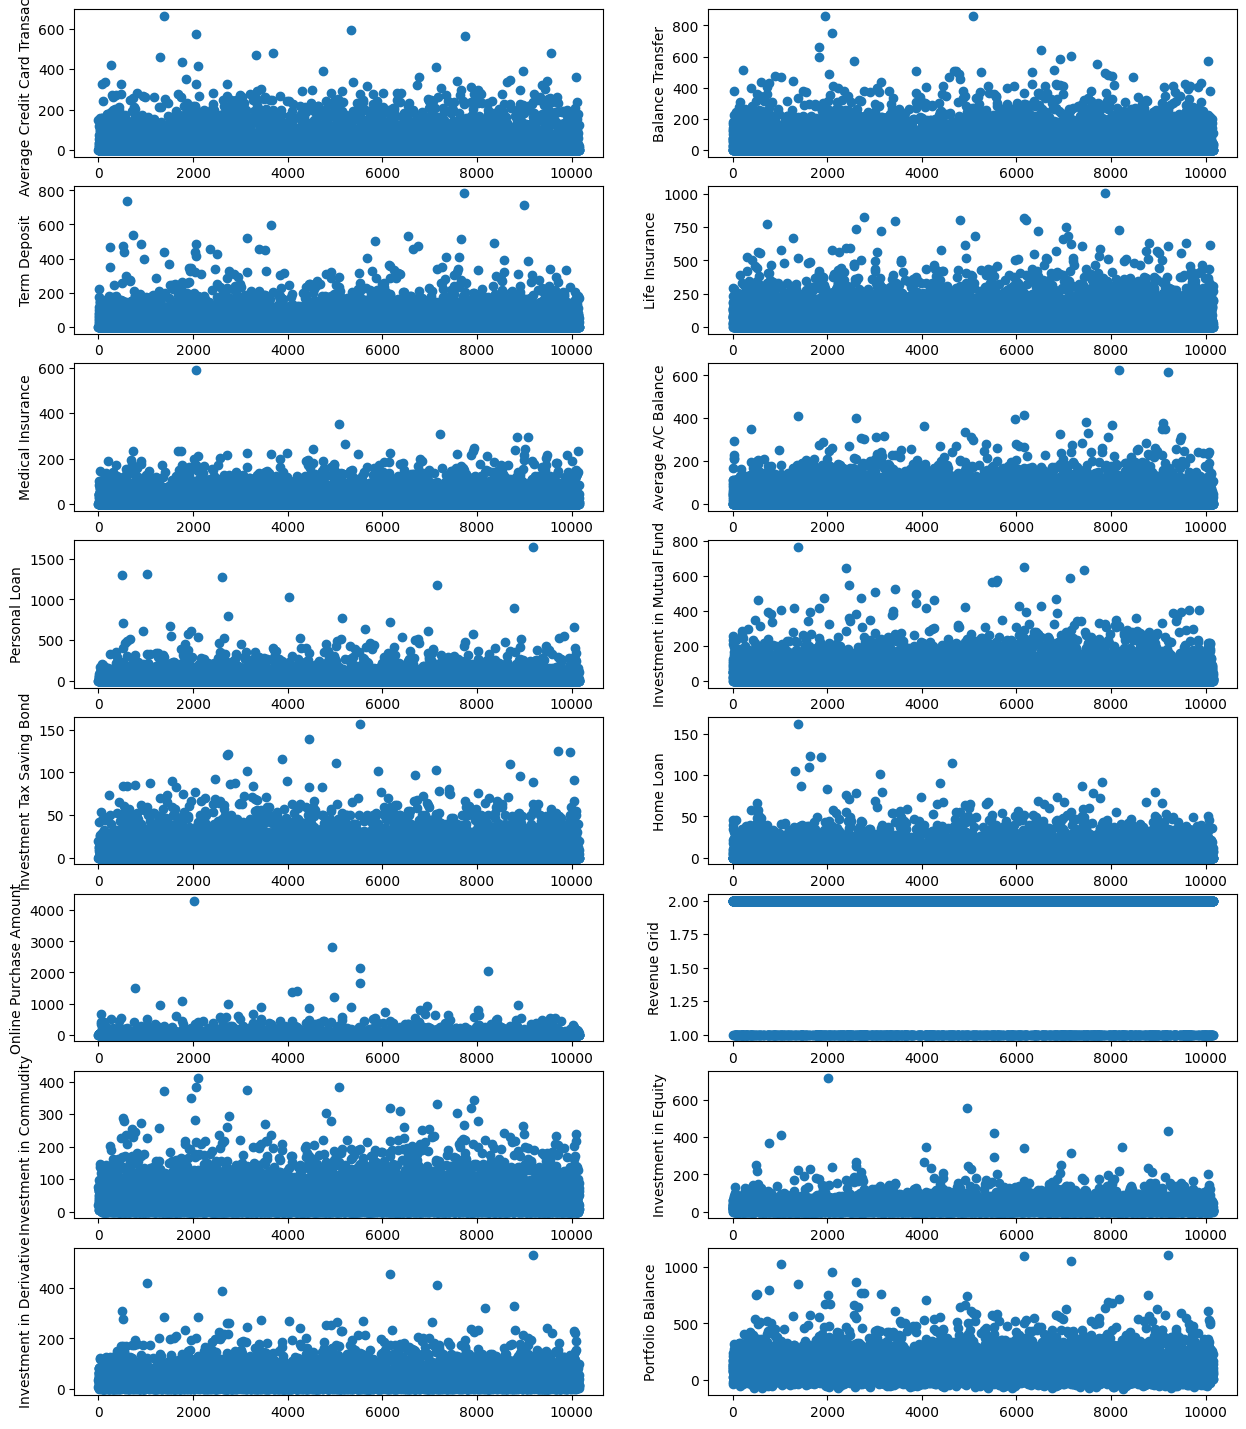

In [49]:
## So We are left with 16 columns now so we wil plot then with 8 rows and 2 columns

col_name1 = list(num_col1.columns) ## Creating a list of column names

r = 8 # Row_Index
c = 2 # Col_Index

n = 0 # Flag to change the index

fig, axes = plt.subplots(nrows=r,ncols=c,figsize =(15,18))

for i in range(r):
    for j in range(c):
        axes[i][j].scatter(y = num_col1[col_name1[n]], x = num_col1.index)
        axes[i][j].set_ylabel(col_name1[n])
        n+=1

Insight:
1. 'Average Credit Card Transactions' : Doesn't require outlier treatment but if need capp at 400.
2. 'Balance_Transfer'. : Doesn't require outlier treatment as such however if we still choose to do capping we will do it at 600
3. 'Term Deposit' : Doesn't require capping as much however if we do, we will capp it at 600
4. 'Life Insurance' : Capping at 800 or not capp
5. 'Medical Insurance' : Capp at 300
6. 'Average AC Balance' : Capp at 350 or 400 or not capp at all.
7. 'Personal Loan' : Capp at 1000.
8. 'Investment in Mutual Fund' : No capping required
9. 'Investment in Tax Saving Bond' : No capping required
10. 'Home Loan' : Capp at 120 or 125 or not capp
11. 'Online Purchase Amount' : Capp it around 1500 or 2000
12. 'Revenue Grid' : No capping required
13. 'Investment in Comodity' : No capping required
14. 'Investment in Equity' : capp at 300 or 400
15. 'Investment in Derivative' : capp at 400
16. 'Portfolio Balance' : No capping required

In [50]:
### Preprocss- 4  : CAPPING numerical columns

numerical_col = data.select_dtypes(exclude='object') ## Selecting Numerical Columns

col_name = list(numerical_col.columns)
col_name.remove('Revenue Grid')  ## Removing Revenue Grid from the Column list

data['Medical Insurance'][data['Medical Insurance']>300]= 300
data['Average A/C Balance'][data['Average A/C Balance']>400] = 400
data['Personal Loan'][data['Personal Loan']>1000] =1000
data['Online Purchase Amount'][data['Online Purchase Amount']>2000]=2000
data['Investment in Equity'][data['Investment in Equity']>400] =400
data['Investment in Derivative'][data['Investment in Derivative']>400] =400


## Alternatively if we want to perform the capping at 99.95th percentile for all the columns we can use the follow

## to find the 99.95th percentile we can either us np.percentile(data, 99.95) or np.quartile(data, 0.9995)

## Only difference is quartile take the value in the of 0 to 1, so 99.95 becomes 0.9995

# for i in col_name:
#percentile_value = np.percentile(data[i], 99.95).round(2) # percentile_value = np.quantile(data[i], 0.9995).round(2)
                                                                # to find the 99.95th Percentile Value
# print(f' Columns {i} has it 99.95th Percentile Value as {percentile_value}')
# data[i][data[i]>percentile_value]=percentile_value
                                            # Replacing all the values greater than percentile to percentile value

In [51]:
##### Sample to show how it works #####

dummy_data = data.copy()
dummy_data

n_c = dummy_data.select_dtypes(exclude='object')
col_n = list(n_c.drop('Revenue Grid', axis =1).columns)

for i in col_n:
    pe = np.percentile(dummy_data[i], 99.95).round(2) # pe = np.quantile(dummy_data[i], 0.9995).round(2)
    print(f' Columns {i} has it 99.95th Percentile Value as {pe}')
    dummy_data[i][dummy_data[i]>pe]=pe # Replacing all the values greater than percentile to percentile value

 Columns Average Credit Card Transaction has it 99.95th Percentile Value as 477.06
 Columns Balance Transfer has it 99.95th Percentile Value as 601.47
 Columns Term Deposit has it 99.95th Percentile Value as 531.11
 Columns Life Insurance has it 99.95th Percentile Value as 794.17
 Columns Medical Insurance has it 99.95th Percentile Value as 264.19
 Columns Average A/C Balance has it 99.95th Percentile Value as 396.74
 Columns Personal Loan has it 99.95th Percentile Value as 992.23
 Columns Investment in Mutual Fund has it 99.95th Percentile Value as 575.8
 Columns Investment Tax Saving Bond has it 99.95th Percentile Value as 119.57
 Columns Home Loan has it 99.95th Percentile Value as 104.3
 Columns Online Purchase Amount has it 99.95th Percentile Value as 1505.06
 Columns Investment in Commudity has it 99.95th Percentile Value as 348.47
 Columns Investment in Equity has it 99.95th Percentile Value as 366.65
 Columns Investment in Derivative has it 99.95th Percentile Value as 329.48
 C

In [52]:
## Preprocess - 5 :  Scaling

## If we obseve closing this dataset doesn't require much of scaling however we are still doing,it doesn't harm the
## dataset.

ss = StandardScaler()
ss.fit(data[col_name]) ## col_name has all the name numerical column name except Revenue Grid
data[col_name] = ss.transform(data[col_name]) ## apply the formula (x-mean)/std on all columns

with open('scaler.pickle', 'wb') as fh: ## Store the ss in the file using pickle which is use to store structrued
    pickle.dump(ss, fh)           ## data know as Serialization.

data[col_name] # Checking the result

Average Credit Card Transaction  Balance Transfer  Term Deposit  \
0                             2.457087          1.326484     -0.511212   
1                            -0.460848          0.395244     -0.511212   
2                            -0.460848          1.648314     -0.121836   
3                            -0.460848         -0.632038     -0.511212   
4                             0.982983          0.162057     -0.511212   
...                                ...               ...           ...   
10150                        -0.460848         -0.632038     -0.511212   
10151                        -0.460848          0.888060     -0.511212   
10152                         1.994943         -0.632038      0.499421   
10153                        -0.460848         -0.139085     -0.511212   
10154                        -0.460848         -0.077706     -0.511212   

       Life Insurance  Medical Insurance  Average A/C Balance  Personal Loan  \
0            0.175401          -0.596747            -0.045189      -0.384346   
1           -0.438176          -0.596747            -0.712042      -0.384346   
2            2.471083          -0.238214             3.000009      -0.384346   
3           -0.498471          -0.596747             0.165384      -0.384346   
4            1.221893           0.713399             0.165607      -0.218046   
...               ...                ...                  ...            ...   
10150       -0.394545          -0.394057            -0.712042      -0.248062   
10151        1.473923          -0.596747            -0.645557      -0.384346   
10152       -0.723095           2.039786            -0.712042      -0.384346   
10153       -0.723095          -0.596747            -0.712042      -0.384346   
10154        2.677947          -0.285060             1.644067       1.236810   

       Investment in Mutual Fund  Investment Tax Saving Bond  Home Loan  \
0                       0.337694                    1.081398  -0.449028   
1                      -0.715773                   -0.476228  -0.449028   
2                      -0.443861                   -0.476228  -0.099418   
3                       0.056939                   -0.476228  -0.449028   
4                       2.903594                   -0.476228   4.150001   
...                          ...                         ...        ...   
10150                  -0.588404                   -0.126366  -0.449028   
10151                  -0.460866                   -0.476228  -0.449028   
10152                  -0.715773                   -0.476228  -0.449028   
10153                  -0.546062                   -0.476228   0.350367   
10154                   0.023269                    1.042438  -0.449028   

       Online Purchase Amount  Investment in Commudity  Investment in Equity  \
0                   -0.239949                 0.942048             -0.100624   
1                   -0.239949                -0.400680             -0.756683   
2                   -0.239949                 1.518524              0.335694   
3                   -0.239949                -0.797238             -0.259189   
4                    0.090928                 0.830893              1.207275   
...                       ...                      ...                   ...   
10150               -0.239949                -0.718617             -0.633628   
10151               -0.239949                 0.636434             -0.651207   
10152               -0.239949                 0.402295             -0.756683   
10153               -0.239949                -0.720835             -0.651559   
10154               -0.239949                 0.879693              0.859908   

       Investment in Derivative  Portfolio Balance  
0                      0.015062          -0.006244  
1                     -0.788571          -0.680400  
2                      1.411587           0.826715  
3                     -0.408432          -1.332606  
4                      1.39665

In [53]:
## Here we perform Serialization to store the values of Mean and Std to perform on the Testing data
## So lets say later if we are required to perform the scalling on testing data then we are not going to calculate
## the mean and std again so in that case we can simple load the data from the file and use the same values to
## transform the test data this process is called Deserialization.

with open('scaler.pickle','rb') as f:
    var = pickle.load(f)

## now this var consists of all the values of mean and std for each column and we can simply apply it on test data
## using var.tranform(x_test)

In [54]:
## Preprocess 6 : - Checing for MISSING VALUES

data.isnull().sum()

children                           0
age_band                           0
status                             0
occupation                         0
occupation_partner                 0
home_status                        0
family_income                      0
self_employed                      0
self_employed_partner              0
TVarea                             0
Average Credit Card Transaction    0
Balance Transfer                   0
Term Deposit                       0
Life Insurance                     0
Medical Insurance                  0
Average A/C Balance                0
Personal Loan                      0
Investment in Mutual Fund          0
Investment Tax Saving Bond         0
Home Loan                          0
Online Purchase Amount             0
Revenue Grid                       0
gender                             0
region                             0
Investment in Commudity            0
Investment in Equity               0
Investment in Derivative           0
Portfolio Balance                  0
dtype: int64

- NO MISSING VALUES

In [55]:
## Preprocess 7 -  Encoding the Categorical Column

cate_data = data.select_dtypes(include='object')
print('Categorical Columns are : ', list(cate_data.columns))

Categorical Columns are :  ['children', 'age_band', 'status', 'occupation', 'occupation_partner', 'home_status', 'family_income', 'self_employed', 'self_employed_partner', 'TVarea', 'gender', 'region']


In [56]:
## So Lets pickup each feature one after other and encode them

## Analysing feature 'children' ###

print(data.children.value_counts())

children
Zero    6208
1       1847
2       1607
3        473
4+        19
Name: count, dtype: int64


Insight
- There are 5 unique values with the most frequently occur are Zero
- Data is Ordinal means here the classes when arranged in order has meaning, eg, class 'Zero' - Means person has No Children, Class '1' mean person has 1 child, Class '2' mean person has 2 chidlren and so on.
- Using Label Encode , we can replace 'Zero' with 0 and '4+' with 4


In [57]:
# Performing Encoding

#data.children[data.children=='Zero']=0
#data.children[data.children=='4+']=4

data.children = data.children.map({'Zero':0,'1':1,'2':2,'3':3, '4+':4})

data.children.value_counts()

children
0    6208
1    1847
2    1607
3     473
4      19
Name: count, dtype: int64

In [58]:
## Analysing Feature 'age_band' ##

print(data.age_band.value_counts())

age_band
45-50      1359
36-40      1134
41-45      1111
31-35      1061
51-55      1052
55-60      1047
26-30       927
61-65       881
65-70       598
22-25       456
71+         410
18-21        63
Unknown      55
Name: count, dtype: int64


Insights:

- Here we have frequcency in the form of range
- It is a Nominal Data not an ordinal data hence label encoding doesn't make any sense here.
- let say we make 18-21 = 0, 22-25 =1 and so on, and someone do the other way round, Here denoting 0 doesn't mean 1359 customer has 'zero' age which is not possible. Also the model with take it a values not an indicator
- logically we have encoded the ranges as an indicator however move will it them as value. So label encoding doesn't make any sense here.

- Lets add unknown to the most prominant class of 45-50
- The mean age of the band could be taken and this column could be converted into a numeric column, however it so can happen that the band actually matters rather than the actual age, hence we create dummies.


In [59]:
# Performing Encoding

data['age_band'][data['age_band']=='Unknown']== '45-50'

age_band_dummies = pd.get_dummies(data.age_band, prefix='age_band') # prefix will add this name before dummy column
                                                                    # name to identify
data = pd.concat([data,age_band_dummies], axis =1)

In [60]:
data.head()

children age_band                status        occupation  \
0         0    51-55               Partner     Manual Worker   
1         0    55-60  Single/Never Married           Retired   
2         0    26-30  Single/Never Married      Professional   
3         0    18-21  Single/Never Married      Professional   
4         0    45-50               Partner  Business Manager   

  occupation_partner home_status      family_income self_employed  \
0  Secretarial/Admin    Own Home  <17,500, >=15,000            No   
1            Retired    Own Home  <27,500, >=25,000            No   
2              Other    Own Home  <30,000, >=27,500           Yes   
3      Manual Worker    Own Home  <15,000, >=12,500            No   
4            Unknown    Own Home  <30,000, >=27,500            No   

  self_employed_partner       TVarea  ...  age_band_31-35  age_band_36-40  \
0                    No          HTV  ...           False           False   
1                    No      Granada  ...           False           False   
2                    No    Tyne Tees  ...           False           False   
3                    No      Central  ...           False           False   
4                    No  Scottish TV  ...           False           False   

   age_band_41-45  age_band_45-50  age_band_51-55  age_band_55-60  \
0           False           False            True           False   
1           False           False           False            True   
2           False           False           False           False   
3           False           False           False           False   
4           False            True           False           False   

   age_band_61-65  age_band_65-70  age_band_71+  age_band_Unknown  
0           False           False         False             False  
1           False           False         False             False  
2           False           False         False             False  
3           False           False         False             False  
4           False           False         False             False  

[5 rows x 41 columns]

In [61]:
## Since the dummies of age_band has been created so we donot need this age band column any more so decide to
## drop it.

data.drop('age_band', axis =1, inplace =True)
removed_col.append('age_band') ## Storing the name in remove_col list

In [62]:
## Analysing feature 'status'

print(data.status.value_counts())

status
Partner                 7708
Single/Never Married    1101
Divorced/Separated       679
Widowed                  618
Unknown                   48
Name: count, dtype: int64


Insight:
- This feature classes has nominal data hence label encoding has no meaning here,We may add unknown to the predominated class 'Partner', however we will stick here with One Hot Encoding as its a Nominal Data.


In [63]:
# Performing Encoding

data.status[data.status=='Unknown']= 'Partner'

status_dummies = pd.get_dummies(data.status, prefix='status') # Getting the dummies

data.drop('status', axis=1, inplace=True) ## Dropping 'status' as dummies are created
removed_col.append('stauts') ## storing the name of dropped column in removed_col list
data = pd.concat([data, status_dummies], axis=1) ## concatinating the dummires with main data.


In [64]:
## Analysing feature 'occupation'

print(data['occupation'].value_counts())

occupation
Professional         2448
Retired              2206
Secretarial/Admin    1797
Housewife            1255
Business Manager      732
Unknown               567
Manual Worker         556
Other                 537
Student                56
Name: count, dtype: int64


- Again a Nominal Data, so label encoding wont make any sense here.
- We will go with one-hot ecnoding and create the dummies and add to the main data


In [65]:
# Performing Encoding

occ_dummies = pd.get_dummies(data.occupation, prefix='occupation') # create dummies

data.drop('occupation', axis=1, inplace=True) # dropping occupation as dummies created

removed_col.append('occupation') ## storing name of dropppd column

data = pd.concat([data,occ_dummies], axis=1) ## concat dummies with main data.

In [66]:
## Analysing feature 'occupation_partner'

print(data.occupation_partner.value_counts())

occupation_partner
Unknown              2394
Professional         2050
Retired              1936
Manual Worker        1508
Business Manager      737
Secretarial/Admin     662
Housewife             527
Other                 324
Student                16
Name: count, dtype: int64


- Again Classes are Nominal so label encoding will not be followed so we will use one-hot encoding


In [67]:
# Performing encoding

occ_par_dummies= pd.get_dummies(data.occupation_partner, prefix='occupation_partner') # creating dummies

data.drop('occupation_partner', axis=1, inplace=True) # dropping 'occupation_parter' as dummies are created

removed_col.append('occupation_partner') ## storing the name of dropped column

data = pd.concat([data,occ_par_dummies], axis=1) ## concat dummies with main data

In [68]:
## Analysing feature 'home_status'

print(data.home_status.value_counts())

home_status
Own Home                9412
Rent from Council/HA     322
Rent Privately           261
Live in Parental Hom     109
Unclassified              50
Name: count, dtype: int64


- Nominal Data One-Hot Encoding will be used.
- Apart form own home the other types seem to be some/kind of rented property and the occurances of those are quite few compared to own house combine all others into a category called rent however we will create dummies


In [69]:
# Performing Encoding

h_dummies = pd.get_dummies(data.home_status, prefix='home_status') # creating dummies

data.drop('home_status', axis=1, inplace=True) # dropping home_status as dummies are created

removed_col.append('home_status') # storing name of dropped column

data = pd.concat([data,h_dummies], axis=1) # concat with main data

In [70]:
## Analysing feature 'family_income'

print(data.family_income.value_counts())

family_income
>=35,000             2516
<27,500, >=25,000    1227
<30,000, >=27,500     994
<25,000, >=22,500     833
<20,000, >=17,500     683
<12,500, >=10,000     677
<17,500, >=15,000     634
<15,000, >=12,500     629
<22,500, >=20,000     590
<10,000, >= 8,000     563
< 8,000, >= 4,000     402
< 4,000               278
Unknown               128
Name: count, dtype: int64


- Nominal Data so label encoding cannot be used
- The family income could be converted into numeric field by taking the mean of the range.
- One thing to note if we decide to take the mean of the range, then we need to Scale the family income column.
- It is impotant as we have already scaled our numerical column we need to scale it too as the range will be high.
- We will explore it in the next set of experiments.
- In the current experiment, we create dummies or go with One Hot Encoding


In [71]:
# Performing Encoding

fa_dummies = pd.get_dummies(data.family_income, prefix='family_income') ## creating dummies

data.drop('family_income', axis=1, inplace=True)## dropping family_income

removed_col.append('family_income') # storing name of dropped column

data = pd.concat([data,fa_dummies], axis=1)# concat dumies with main data

In [72]:
## Analysing feature 'self_employed'

print(data.self_employed.value_counts())

self_employed
No     9435
Yes     719
Name: count, dtype: int64


- Ordinal Data and label encoding can be used


In [73]:
# Performing Encoding

data.self_employed = data.self_employed.map({'Yes':1, 'No':0})

print(data.self_employed.value_counts()) # checking the result

self_employed
0    9435
1     719
Name: count, dtype: int64


In [74]:
## Analysing Feature 'self_employed_partner'

print(data.self_employed_partner.value_counts())

self_employed_partner
No     9025
Yes    1129
Name: count, dtype: int64


- Ordinal Data Label Encoding can be used

In [75]:
# Performing Encoding

data.self_employed_partner = data.self_employed_partner.map({'Yes':1, 'No':0})

print(data.self_employed_partner.value_counts()) ## checking the result

self_employed_partner
0    9025
1    1129
Name: count, dtype: int64


In [76]:
## Analysing Feature 'TVarea'

print(data.TVarea.value_counts())

TVarea
Central          1618
Carlton          1541
Meridian         1226
Yorkshire        1042
Granada          1039
HTV               845
Anglia            751
Tyne Tees         535
Scottish TV       520
TV South West     363
Grampian          227
Unknown           189
Ulster            159
Border             99
Name: count, dtype: int64


- Nominal data so label encoding doesn't make any sense here.
- Intuitively, TVArea doesn't make sense in predicting if the user is a high transaction user or not.
-  In the current set we would be removing this column, however doing this might lead to loss of information if it is relevant in anyway. This is a judgemental call. Here we decide to keep it


In [77]:
# Perfornign encoding

tv_dummies = pd.get_dummies(data.TVarea, prefix='TV') # creating dummies

data.drop('TVarea', axis=1, inplace=True) # dropping 'TVarea' as dummies are created

removed_col.append('Tvarea') ## storing name of dropped column

data = pd.concat([data,tv_dummies], axis=1) ## adding dummies to main data

In [78]:
## Analysing Feature 'gender'

print(data.gender.value_counts())

gender
Female     7634
Male       2485
Unknown      35
Name: count, dtype: int64


- Again due to Unknown categotry it becomes Nominal so we will use dummies or One Hot Encoding


In [79]:
# Performing Encoding

gender_dummies = pd.get_dummies(data.gender, prefix='gender') # creating dummies

data.drop('gender', axis=1, inplace=True) # dropping 'gender' as dummies are created

removed_col.append('gender') ## storing name of dropped column

data = pd.concat([data,gender_dummies], axis=1) ## adding dummies to main data

In [80]:
## Analysing feature 'region'

print(data.region.value_counts())

region
South East          2100
North West          1896
Unknown             1080
South West           971
West Midlands        820
Scotland             787
East Midlands        771
North                570
Wales                556
East Anglia          423
Northern Ireland     159
Isle of Man           16
Channel Islands        5
Name: count, dtype: int64


- Nominal data so One'Hot Encoding will be used


In [81]:
# Perforing Encoding

region_dummies = pd.get_dummies(data.region, prefix='region') # creating dummies

data.drop('region', axis=1, inplace=True) # dropping 'region' as dummies are created

removed_col.append('region') ## storing name of dropped column

data = pd.concat([data,region_dummies], axis=1) ## adding dummies to main data

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10154 entries, 0 to 10154
Columns: 102 entries, children to region_West Midlands
dtypes: bool(83), float64(15), int64(4)
memory usage: 2.4 MB


In [83]:
## Data Usage is High thats why it not showing the column info. However it is clear from the info that we donot
## have any object columns
## Now we are done with preprocessing part. We will move to the next stage i.e Model Building

- Data Usage is High thats why it not showing the column info. However it is clear from the info that we donot have any object columns.
- Now we are done with preprocessing part. We will move to the next stage i.e Model Building

In [84]:
## Now we are dealing with classification problem so we will convert the Target Variable to 0 and 1

data['Revenue Grid'].value_counts()

Revenue Grid
2    9068
1    1086
Name: count, dtype: int64

In [85]:
data['Revenue Grid'].dtype

dtype('int64')

In [86]:
## Here we will convert class 2 to 0

data['Revenue Grid'][data['Revenue Grid']==2]=0 # This will replace all 2 with 0

data['Revenue Grid'].value_counts()

Revenue Grid
0    9068
1    1086
Name: count, dtype: int64

In [87]:
data.reset_index(drop=True, inplace=True)## This will reset the index

### Model Data Prepration

In [88]:
## In the first Iteration of any model building since we have 109 column we will not apply PCA here, We will evaluate
## the model in it Raw form to observe the evaluation matirx parameters and then we will implement other things
## to check if we can increase the model performance

## Spliting the data

x = data.drop('Revenue Grid', axis = 1)
y = data['Revenue Grid']

In [89]:
x.shape , y.shape # Checking the shape of Training and Validation Dataset

((10154, 101), (10154,))

In [90]:
## Now if we observe the Target Variable
data['Revenue Grid'].value_counts()

Revenue Grid
0    9068
1    1086
Name: count, dtype: int64

In [91]:
a = (9086/(9068+1086))*100
b = (1086/(9068+1086))*100
print('Class 0 proportion : ',round(a,2))
print('Class 1 proportion : ',round(b,2))

Class 0 proportion :  89.48
Class 1 proportion :  10.7


In [92]:
## This is a Huge class imbalance.
## Class 1 ~ 10.70 % and Class 0 ~ 89.48%

## So the idea to maintain the same balance in the training and validation data so that we donot change the proportion
## For this we use Stratified Split

## There are 2 ways to do stratified splitiing

## 1. using train_test_split() and pass validation set as parameter to stratify argument.
## 2. using stratified split

## Lets try to see both

x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8, stratify=y, random_state=10)

In [93]:
y_train.value_counts() ## Check the frequcies of each class in training

Revenue Grid
0    7254
1     869
Name: count, dtype: int64

In [94]:
print(' Class 0 proportion : ', round((869/(869+7254))*100,2))
print(' Class 1 proportion : ', round((7254/(869+7254))*100,2))

 Class 0 proportion :  10.7
 Class 1 proportion :  89.3


In [95]:
## Here we can observe the proportion of each class in training is similar to that of original data

In [96]:
## Spliting through Stratifiedsplit

sp = StratifiedShuffleSplit(train_size=0.8, random_state=10) ##

split = sp.split(x,y) ## This function returns the index of training and validation

## Now to seperate x_train, x_test, y_train, y_test we will run a for loop

for i, j in split:
    x1_train = x.iloc[i,:]
    x1_test = x.iloc[j,:]
    y1_train = y[i]
    y1_test = y[j]

In [97]:
x1_train.shape , x1_test.shape ## 80-20 split

((8123, 101), (2031, 101))

In [98]:
y1_train.shape, y1_test.shape ## 80-20 split

((8123,), (2031,))

In [99]:
y1_test.value_counts()

Revenue Grid
0    1814
1     217
Name: count, dtype: int64

In [100]:
print(' Class 0 proportion : ', round((1814/(1814+217))*100,2))
print(' Class 1 proportion : ', round((217/(1814+217))*100,2))

 Class 0 proportion :  89.32
 Class 1 proportion :  10.68


In [101]:
## Here we can observe the proportion of each class in training is similar to that of original data

In [102]:
### So its upto us which method we follow

In [103]:
## Resetting the Index

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Model Buliding

In [104]:
## We will Start with fitting Logistic Regression Model,this would serve as benchmark model ##

## Logistic Regression

## Initialising the Model Object

lr_model = LogisticRegression(penalty='l2',
                              class_weight={0:0.45, 1:0.55},
                              max_iter=1000,
                              random_state=10
                             )

# 'class_weight' - Use to handle the class imbalance in Target Variable, takes dictionary
## {class 1 : proporiton, class 2: proportion, ..} and default value is Balanced

# max_iter - No. of iteration model with iterate over. Lower value may result is model to fail as it may not reach
# to the minima, Higher value is not an issue, as lets say we give max_iter= 10000 , and the model reaches the
# minima at 5000th iteration and then the model will run unnecesarility in the loop for more 5000 iteration.

# Fitting the Model

lr_model.fit(x_train, y_train)

LogisticRegression(class_weight={0: 0.45, 1: 0.55}, max_iter=1000,
                   random_state=10)

In [105]:
lr_model.coef_.shape

(1, 101)

In [106]:
## Let check the coef value of each feature

## So lr_model.coef_[0] with give a ndarray of the all the coefficients
## and we can covert them into dictionary using zip and dict funt

## About zip()

## In Python, the zip() function is used to combine two or more lists (or any other iterables) into a single
## iterable, where elements from corresponding positions are paired together. The resulting iterable contains
## tuples, where the first element from each list is paired together, the second element from each list is
## paired together, and so on.

## Example

a = [1,2,3,4,5]
b = ['a', 'b', 'c', 'd','e']

dict(zip(a,b)) ## So this will iterate over both the dic and combine them as key value pair


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e'}

In [107]:
dict(zip(list(x.columns),list(lr_model.coef_[0])))

{'children': 0.09011885028014707,
 'self_employed': 0.09969260436295273,
 'self_employed_partner': 0.1622715025920918,
 'Average Credit Card Transaction': 0.9904016661089684,
 'Balance Transfer': -0.46268406353451635,
 'Term Deposit': -0.9714920541872589,
 'Life Insurance': 1.3342308478104286,
 'Medical Insurance': -0.4003622716913905,
 'Average A/C Balance': -0.3594496161229624,
 'Personal Loan': -1.810996249910332,
 'Investment in Mutual Fund': 0.0712360645876431,
 'Investment Tax Saving Bond': 1.1036701886569171,
 'Home Loan': -0.6545251394395926,
 'Online Purchase Amount': 3.5598481626506855,
 'Investment in Commudity': 0.36026066554573044,
 'Investment in Equity': 0.12922164570012362,
 'Investment in Derivative': -0.6838194045639016,
 'Portfolio Balance': -0.010595574582697989,
 'age_band_18-21': 0.08099283765616772,
 'age_band_22-25': -0.1623798466213052,
 'age_band_26-30': 0.18183836614430607,
 'age_band_31-35': -0.11678229222631067,
 'age_band_36-40': 0.031455883898621854,
 'ag

Insight
So higher the ABSOLUTE coefficient value of a particular feature higher is its importance
- 'Online Purchase Amount': 3.5102265394175185
- Investment Tax Saving Bond': 1.0900043392935201
- Personal Loan': 1.8786936088108162(Absolute Value)
- 'Average Credit Card Transaction': 0.9935838309788008
- 'Term Deposit': 0.9670468939384689(Absolute Value)
- 'Life Insurance': 1.299203582362492

- So these features are uttermost important to have an idea

In [108]:
## Looking into probabilities

## Since Logistic Regression always gives us the soft classes(Probabilites)i.e probablities where the data point
## belongs to class '0' or class '1'
## we can get this using lr_model.predict_proba()
## lr_model.predict >> it will gives us hard classes and its a combination of lr_model.predict_proba + 0.5 threshold
## which means any datapoint which has probobility more than 0.5 will be long to that class.
## lr_model.predict is basically applying a threshold of 0.5 on lr_model.predict_proba and making the decision.


y_predict_proba_train = lr_model.predict_proba(x_train) # Calculating for training data
y_predict_proba_test = lr_model.predict_proba(x_test) # calculating for testing data

y_pred_train = lr_model.predict(x_train)
y_pred_test = lr_model.predict(x_test)

In [109]:
## Comparing the Prediction with Actual for training and validation

compare_train = pd.DataFrame({'Actual Training Data': y_train, 'Predicted Training Data': y_pred_train })
compare_test = pd.DataFrame({'Actual Testing Data': y_test, 'Predicted Testing Data': y_pred_test })

compare_train

Actual Training Data  Predicted Training Data
0                        0                        0
1                        0                        0
2                        0                        0
3                        0                        0
4                        1                        1
...                    ...                      ...
8118                     0                        0
8119                     0                        0
8120                     0                        0
8121                     0                        0
8122                     0                        1

[8123 rows x 2 columns]

In [110]:
compare_test

Actual Testing Data  Predicted Testing Data
0                       0                       0
1                       0                       0
2                       1                       1
3                       0                       0
4                       0                       0
...                   ...                     ...
2026                    0                       0
2027                    0                       0
2028                    0                       0
2029                    0                       0
2030                    1                       0

[2031 rows x 2 columns]

In [111]:
compare_train.shape

(8123, 2)

### Model Evaluation

In [112]:
## Model Evaluation Matrix

## We will now calcuate the model performance based on evaluation matrix parameters
## Lets start with Accuracy Score

## Accuracy Score
## In our problem, since there is a class imbalance so accuracy is not a good parameter for model evaluation.
## However we will check it.

## 1 way to is to us the compare data frame and other way is to use accuracy_score
## both will give the same result.


accuracy_train = np.sum(compare_train['Actual Training Data']==compare_train['Predicted Training Data'])/compare_train.shape[0]

accuracy_test = np.sum(compare_test['Actual Testing Data']==compare_test['Predicted Testing Data'])/compare_test.shape[0]


## accu_train = accuracy_score(y_train)
## accu_test = accuracy_score(y_test)

print('Training Accuracy : ', accuracy_train)
print('Testing Accuracy : ', accuracy_test)

Training Accuracy :  0.9460790348393451
Testing Accuracy :  0.9453471196454948


- So the model is giving us very good Accuracy for Training and Testing, however we cannot trust accuracy as there is class imbalance so we will evaluate other parameters, like F1-Score, Roc, AUC, Classfication Report, Confusion Matrix

Training Confusion Matrix


Training F1 Score :  0.7166882276843467


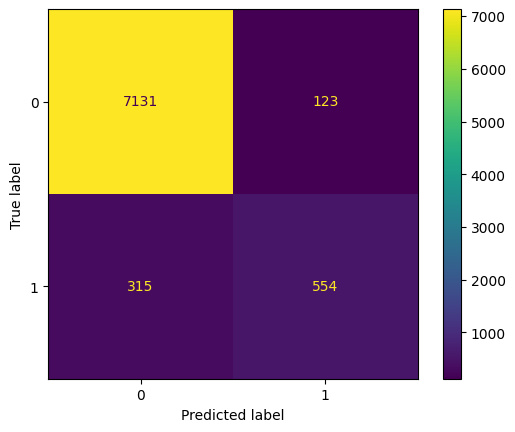

In [113]:
## Confusion Matrix and F1-Score

from sklearn.metrics import f1_score, ConfusionMatrixDisplay

## For Training

print('Training Confusion Matrix')
print(ConfusionMatrixDisplay.from_estimator(lr_model,x_train,y_train))

print('\n\nTraining F1 Score : ', f1_score(y_train, y_pred_train))


Testing Confusion Matrix

Testing F1 Score :  0.7024128686327078


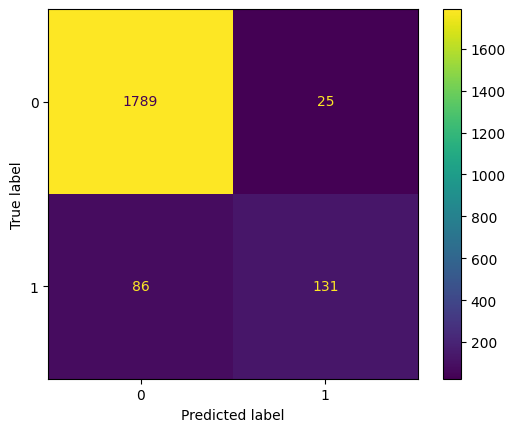

In [114]:
## For Testing

print('Testing Confusion Matrix')
print(ConfusionMatrixDisplay.from_estimator(lr_model,x_test,y_test))

print('\nTesting F1 Score : ', f1_score(y_test , y_pred_test))



In [115]:
## Classification report

# For training

print('Classificaiton Report For Training \n')
print(classification_report(y_train, y_pred_train))

Classificaiton Report For Training 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7254
           1       0.82      0.64      0.72       869

    accuracy                           0.95      8123
   macro avg       0.89      0.81      0.84      8123
weighted avg       0.94      0.95      0.94      8123



In [116]:
## For Testing/Validation

print('Classification Report fo Testing \n')
print(classification_report(y_test, y_pred_test))

Classification Report fo Testing 

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1814
           1       0.84      0.60      0.70       217

    accuracy                           0.95      2031
   macro avg       0.90      0.79      0.84      2031
weighted avg       0.94      0.95      0.94      2031



In [117]:
## Due to class Imbalance, our model tend to show low scores of class '1' in both training and tesitng

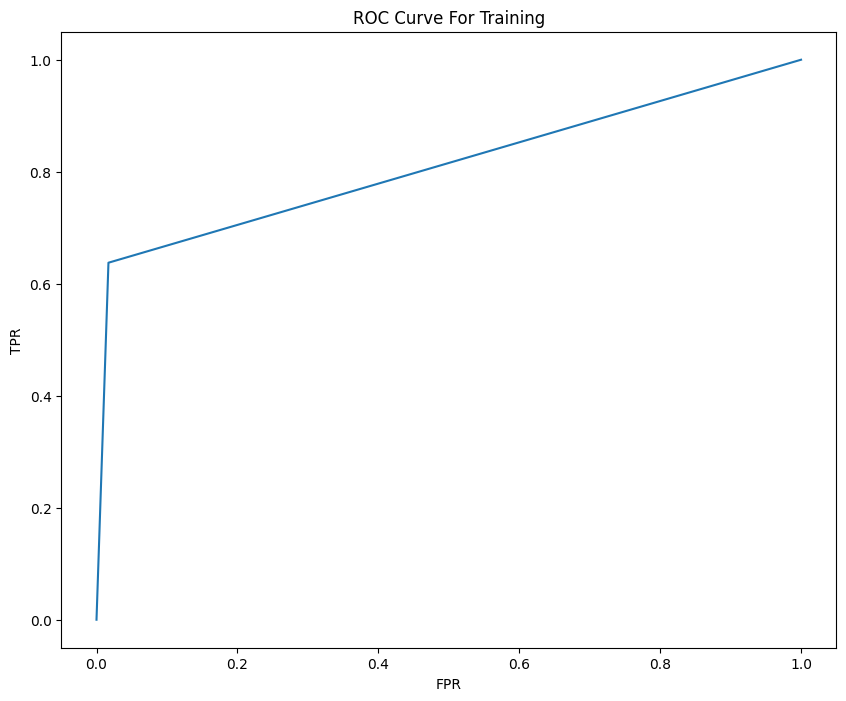



AUC for Training :  0.8102791111161874


In [118]:
## AUG and ROC Curve

## For Training

fpr_tr, tpr_tr, _ = roc_curve(y_train, y_pred_train)

plt.figure(figsize=(10,8))
plt.plot(fpr_tr, tpr_tr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve For Training')
plt.show()


print('\n\nAUC for Training : ', roc_auc_score(y_train,y_pred_train))

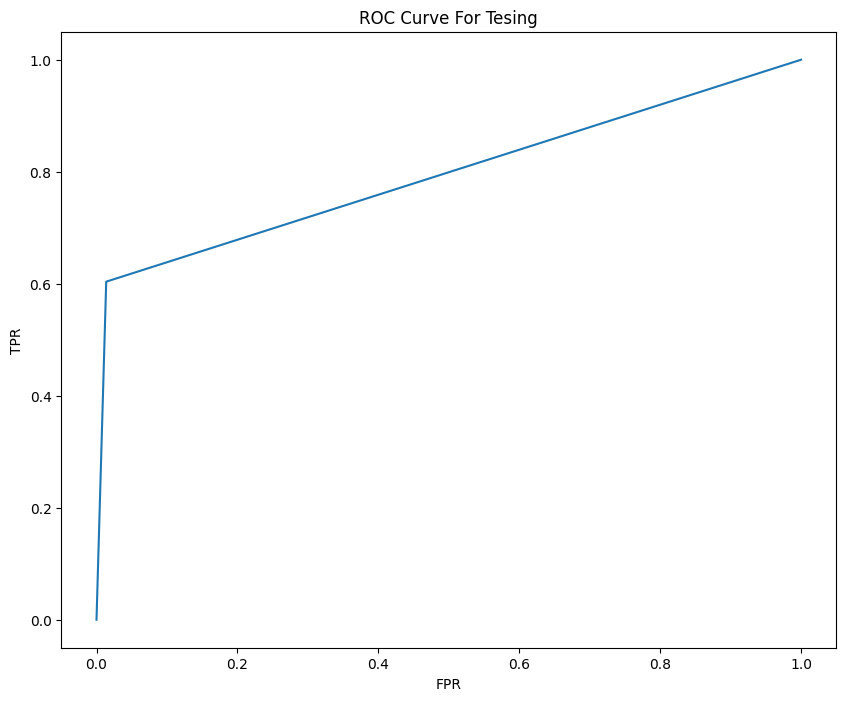



AUC for Testing :  0.7949524690197594


In [119]:
## For Testing

fpr, tpr, _ = roc_curve(y_test,y_pred_test)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve For Tesing')
plt.show()

print('\n\nAUC for Testing : ', roc_auc_score(y_test,y_pred_test))

In [120]:
## So we can see that our AUC score is poor for both training and testing, so there are 3 things that we can do.

## 1. Optimize the Hyper parameter for Logistic Regression
## 2. Build Another Model
## 3. Redo Pre-processing (This is the last step)

In [121]:
## Let Try to implement another classifier i.e Decision Tree CLassifier


##### We experiment ###
#### max_depth = 5, max_features = 8,   min_samples_split = 10, criterion = 'gini' --> Training f1 score, val f1 score
#### max_depth = 7, max_features = 10,  min_samples_split = 8 --> Trining f1 score, val f1 score
#### max_depth = 9, max_features = 12,  min_samples_split = 6 --> Trining f1 score, val f1 score
#### max_depth = 20, max_features = 69, min_sample_split = 2 --> Training F1 score, val f1 score
#### max_depth = 15, max_features = 50, min_sample_split = 5 --> Training F1 score, val f1 score

dt = DecisionTreeClassifier(class_weight='balanced', max_depth=5, criterion='gini', min_samples_split=30)
                                                    ## Initialising the Model Object
dt.fit(x_train, y_train) ## Fitting the model with training data

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=30)

In [122]:
## Let predict the output for training and test

y_pred_train_DT = dt.predict(x_train)
y_pred_test_DT = dt.predict(x_test)


y_pred_proba_train_DT = dt.predict_proba(x_train)
y_pred_proba_test_DT = dt.predict_proba(x_test)

In [123]:
## Now there is an important output parameter known as feature_importance which tells the which features are more
## important in terms of information gain.That means the features which gives the highest information gain are more
## important and it also depends on the length of the tree or the depth of the tree upto which we train our model.

## We will again use the zip() and dict() to create a dictionary of these features.

dict(zip(list(x.columns), list(dt.feature_importances_)))

{'children': 0.0,
 'self_employed': 0.0,
 'self_employed_partner': 0.0,
 'Average Credit Card Transaction': 0.05595278268497217,
 'Balance Transfer': 0.0,
 'Term Deposit': 0.023645475761287636,
 'Life Insurance': 0.07846708268301643,
 'Medical Insurance': 0.0038102966812814804,
 'Average A/C Balance': 0.0019322314004809205,
 'Personal Loan': 0.04361741153135381,
 'Investment in Mutual Fund': 0.010296761289261337,
 'Investment Tax Saving Bond': 0.18891581320083925,
 'Home Loan': 0.004403801627286232,
 'Online Purchase Amount': 0.399193747821401,
 'Investment in Commudity': 0.1897645953188197,
 'Investment in Equity': 0.0,
 'Investment in Derivative': 0.0,
 'Portfolio Balance': 0.0,
 'age_band_18-21': 0.0,
 'age_band_22-25': 0.0,
 'age_band_26-30': 0.0,
 'age_band_31-35': 0.0,
 'age_band_36-40': 0.0,
 'age_band_41-45': 0.0,
 'age_band_45-50': 0.0,
 'age_band_51-55': 0.0,
 'age_band_55-60': 0.0,
 'age_band_61-65': 0.0,
 'age_band_65-70': 0.0,
 'age_band_71+': 0.0,
 'age_band_Unknown': 0.0

Insight:
Result are similar to that of logistic regression where we checked the coefficient values of each features.

- 'Online Purchase Amount': 0.39919374782140493,
- Investment Tax Saving Bond': 0.18891581320083642
- Personal Loan': 0.043617411531352186,
- 'Average Credit Card Transaction': 0.05595278268497239,
- 'Term Deposit': 0.023645475761288722
- 'Life Insurance': 0.07846708268300848,

- Now one thing to note here is that most features has 0 value, the reason for that is we select the max_depth =5 that mean these features didn't get capture upto depth 5 so the value is showing Zero.
- For eg, if we keep max_depth = 2, almost every feature will become zero, it doesn't mean that feature is not important. Its just that it is not captured during the tree formation or model building.



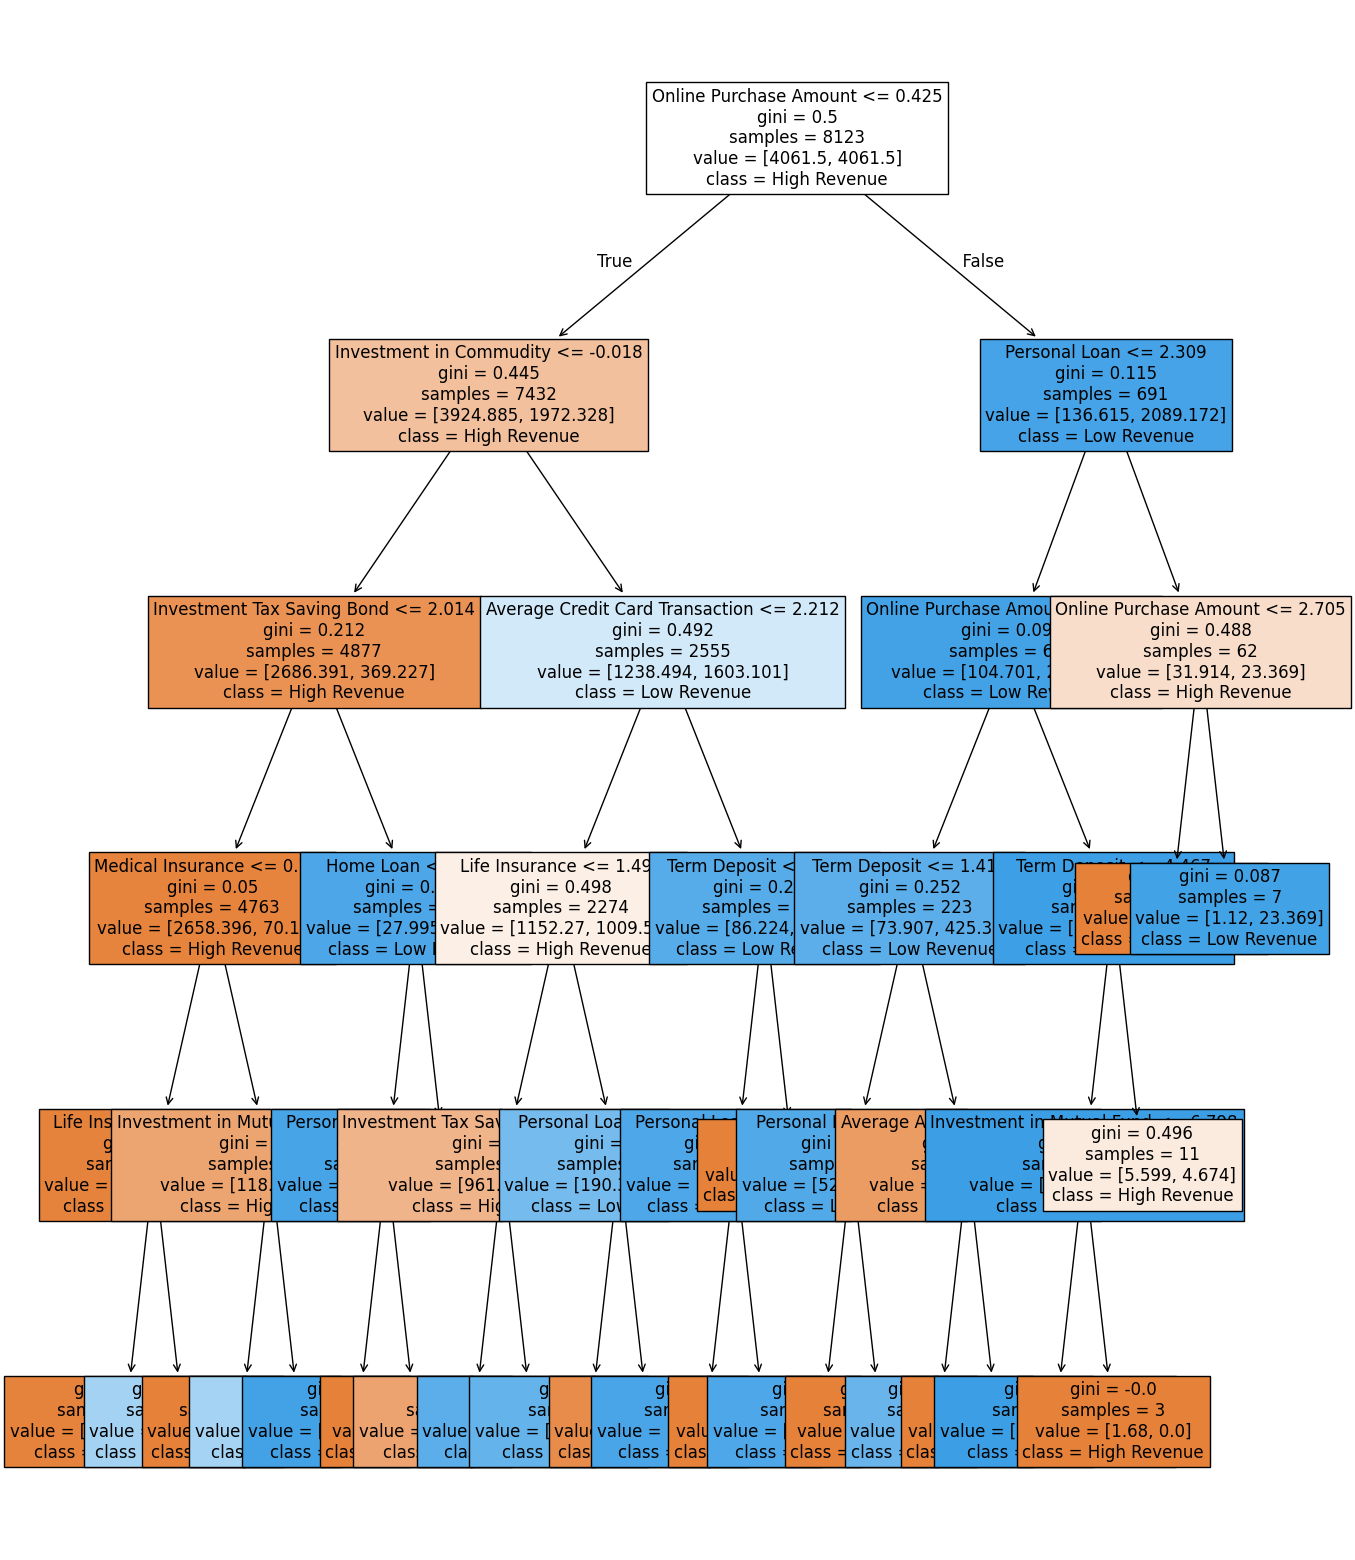

In [124]:
## Ploting the tree

from sklearn.tree import plot_tree

plt.figure(figsize=(15,20))
plot_tree(dt,filled=True, feature_names=x.columns,class_names=['High Revenue','Low Revenue'], fontsize=12)
plt.show()

Training Accuracy :  0.9230579835036317

Classification Report for Training

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      7254
           1       0.59      0.93      0.72       869

    accuracy                           0.92      8123
   macro avg       0.79      0.93      0.84      8123
weighted avg       0.95      0.92      0.93      8123


 F1-Score for Training :  0.7206079570853822

AUC Score for Training :  0.9656902917417413


Confusion Matrix for Training 



Text(0.5, 1.0, 'ROC Curve')

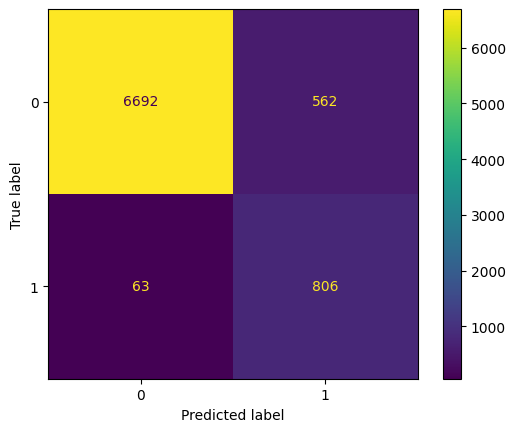

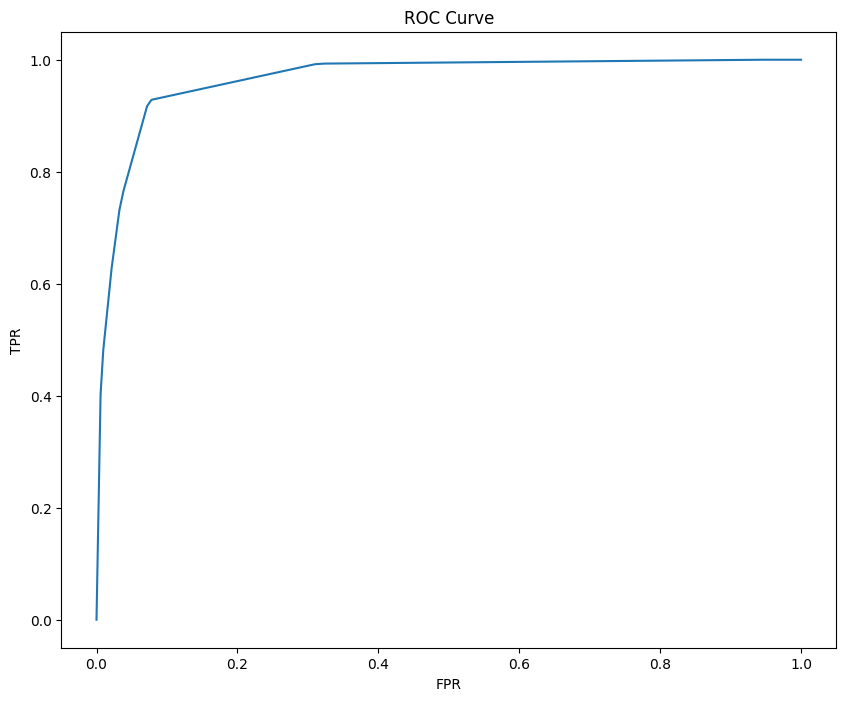

In [125]:
## Model Evaluation Matrix

# For Training


print('Training Accuracy : ', dt.score(x_train, y_train))

print('\nClassification Report for Training\n')
print(classification_report(y_train, y_pred_train_DT))


print('\n F1-Score for Training : ', f1_score(y_train, y_pred_train_DT))


fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train_DT[:,1])


print('\nAUC Score for Training : ', roc_auc_score(y_train,y_pred_proba_train_DT[:,1]))


print('\n\nConfusion Matrix for Training \n')
ConfusionMatrixDisplay.from_estimator(dt,x_train, y_train)



plt.figure(figsize=(10,8))
plt.plot(fpr_train, tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

Training Testing :  0.9330379123584441

Classification Report for Testing 

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1814
           1       0.62      0.94      0.75       217

    accuracy                           0.93      2031
   macro avg       0.81      0.93      0.86      2031
weighted avg       0.95      0.93      0.94      2031


 F1-Score for Testing :  0.7490774907749077

AUC Score for Testing :  0.9582801965257419


Confusion Matrix for Testing 



Text(0.5, 1.0, 'ROC Curve')

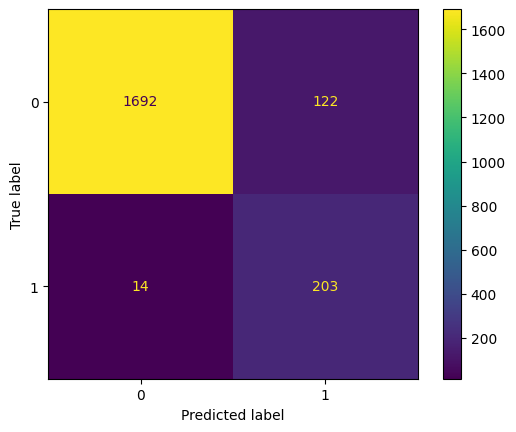

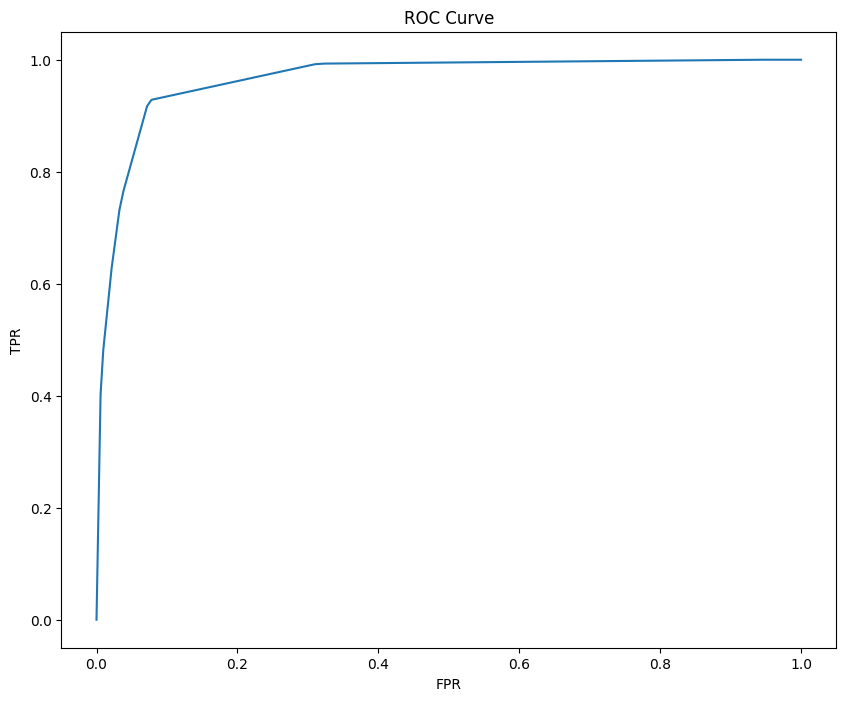

In [126]:
# For Testing


print('Training Testing : ', dt.score(x_test, y_test))

print('\nClassification Report for Testing \n')
print(classification_report(y_test, y_pred_test_DT))


print('\n F1-Score for Testing : ', f1_score(y_test, y_pred_test_DT))


fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test_DT[:,1])


print('\nAUC Score for Testing : ', roc_auc_score(y_test,y_pred_proba_test_DT[:,1]))


print('\n\nConfusion Matrix for Testing \n')
ConfusionMatrixDisplay.from_estimator(dt,x_test, y_test)



plt.figure(figsize=(10,8))
plt.plot(fpr_train, tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')




In [127]:
## So we have Training F1-Score = 72.06 and Testing F1-Score = 74.90

## Again we can either Hypertune the Model Parameters, Change Model or Dopreprocessing again.

## In terms of tuning its always heat and trial error. We select different parameters and observe different values
## for F1-Score and others to give the final output.
## However we also use GridSearchCV() which is basically a technique by which we can automate the manual hyper
## parameter tunning and it is function which consists of all the hyperparamerters of all the models and we pass
## diferent values of each paramter in the form of dictionary.
## and this function gives us the best parameters values of the model.

## Hypertunning Using GridSearchCv()


dtc = DecisionTreeClassifier()

grid = {'class_weight':[None,'balanced', {0:0.4,1:0.6}, {0:0.55, 1:0.45}, {0:0.45, 1:0.55}],
        'max_depth' : [5,6,7,8,9,10],
        'criterion' :['gini', 'entropy'],
        'min_samples_split' : [5,10,20,50],
        'max_features': [None, 0.8, 0.9]
       }

grid_search = GridSearchCV(dtc, param_grid=grid, cv=5, verbose=True, scoring='f1',return_train_score=True ,n_jobs=-1)

## return_train_score will return the avg F1 Training Score, By default GridSearchCV() on gives test score
## but if need training score too we need to set return_train_score to True


grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced', {0: 0.4, 1: 0.6},
                                          {0: 0.55, 1: 0.45},
                                          {0: 0.45, 1: 0.55}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'max_features': [None, 0.8, 0.9],
                         'min_samples_split': [5, 10, 20, 50]},
             return_train_score=True, scoring='f1', verbose=True)

In [128]:
## Now we have fit the GridSearchCV() and now look at the resultant parameters

## 1. cv_result_ gives a dictonary , we need to focus on the keys of this dictonary

list(grid_search.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_class_weight',
 'param_criterion',
 'param_max_depth',
 'param_max_features',
 'param_min_samples_split',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score',
 'split0_train_score',
 'split1_train_score',
 'split2_train_score',
 'split3_train_score',
 'split4_train_score',
 'mean_train_score',
 'std_train_score']

In [129]:
## 'params'- will gives us all the parameters combinations that our model tried.

len(grid_search.cv_results_['params'])

720

In [130]:
## That means my model tried 720 combinatons

## To check the combinations we use indexing

## First combination that model tried will be at 0 index

grid_search.cv_results_['params'][0] ## similarly we can try of different values, 1,23,300, 400, ...719

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'min_samples_split': 5}

In [131]:
## Next Paramater we need to focus on is mean_train_score , mean_test_score

## mean_train_score and mean_test_score will give the mean train F1 Score and mean test F1 Score for a particular
## combination
## So lets say I need calculate the mean_train_score and mean_test_score for 0th combination we give,

print('0th Combination : ', grid_search.cv_results_['params'][0])
print('Training F1 Score for 0th Combination  : ', grid_search.cv_results_['mean_train_score'][0])
print('Testing F1 Score for 0th Combination  : ', grid_search.cv_results_['mean_test_score'][0])

0th Combination :  {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_split': 5}
Training F1 Score for 0th Combination  :  0.7943346769098094
Testing F1 Score for 0th Combination  :  0.7228977660148889


In [132]:
## For 10th combination

print('10th Combination : ', grid_search.cv_results_['params'][10])
print('Training F1 Score for 10th Combination  : ', grid_search.cv_results_['mean_train_score'][10])
print('Testing F1 Score for 10th Combination  : ', grid_search.cv_results_['mean_test_score'][10])

10th Combination :  {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 0.9, 'min_samples_split': 20}
Training F1 Score for 10th Combination  :  0.7783095927903237
Testing F1 Score for 10th Combination  :  0.7047450632739145


In [133]:
## Similary 'std_train_score'  & 'std_test_score' will give the Standard Deviation for train and test

# For 0th Combination


print('0th Combination : ', grid_search.cv_results_['params'][0])
print('Training Standard Deviaton for 0th Combination  : ', grid_search.cv_results_['std_train_score'][0])
print('Testing Standard Deviation for 0th Combination  : ', grid_search.cv_results_['std_test_score'][0])


0th Combination :  {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_split': 5}
Training Standard Deviaton for 0th Combination  :  0.013883182460092415
Testing Standard Deviation for 0th Combination  :  0.021428199539597174


In [134]:
## 'split0_train_score', and 'split0_test_score', gives the F1-Score train and test score for the 0th fold of
## 0th combination

print('0th Combination : ', grid_search.cv_results_['params'][0])
print('Training F1-Score for 0th Split for 0th Combination  : ', grid_search.cv_results_['split0_train_score'][0])
print('Testing F1-Score for 0th Split for 0th Combination  : ', grid_search.cv_results_['split0_test_score'][0])



0th Combination :  {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_split': 5}
Training F1-Score for 0th Split for 0th Combination  :  0.7678300455235205
Testing F1-Score for 0th Split for 0th Combination  :  0.69375


In [135]:
## 'rank_test_score' will give the array of ranks of the best testing F1 Score from 720 combinations

grid_search.cv_results_['rank_test_score']

array([512, 527, 511, 519, 531, 412, 550, 589, 556, 562, 603, 514, 368,
       314, 315, 364, 290, 491, 334, 375, 299, 210, 233, 440, 149, 104,
       137, 197, 246, 325, 206, 407,  98, 370, 198, 260,  85,  66,  71,
       150, 171,  91, 159, 205,  81, 258, 161, 119,  60,  53,  51, 170,
       199, 262, 267, 384,  47,  72, 259, 172, 190, 154,  70, 239, 324,
       458, 183, 376, 128, 117, 178, 223, 615, 620, 618, 630, 667, 593,
       648, 594, 541, 640, 617, 574, 430, 428, 432, 425, 374, 507, 450,
       427, 498, 466, 609, 503, 510, 518, 524, 473, 542, 467, 411, 535,
       406, 359, 388, 337, 305, 347, 342, 336, 123, 207, 167, 327, 460,
       417, 470, 312, 321, 248, 208, 272, 269, 250, 132, 224, 195, 291,
       166, 114,  83, 135, 133, 125, 396, 323,  94,  76, 398, 221,  59,
       148, 656, 651, 657, 686, 691, 655, 709, 717, 694, 660, 705, 626,
       669, 664, 676, 698, 644, 696, 712, 688, 716, 672, 598, 702, 523,
       528, 538, 595, 544, 543, 583, 719, 547, 597, 611, 685, 29

In [136]:
## So the Best Tesing F1 Score is observed for 701th combination which is at 700th index

## For 701th cobination

print('701th Combination : ', grid_search.cv_results_['params'][700])
print('Training F1-Score for 0th Split for 701th Combination  : ', grid_search.cv_results_['mean_train_score'][700])
print('Testing F1-Score for 0th Split for 701th Combination  : ', grid_search.cv_results_['mean_test_score'][700])



701th Combination :  {'class_weight': {0: 0.45, 1: 0.55}, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 0.8, 'min_samples_split': 5}
Training F1-Score for 0th Split for 701th Combination  :  0.9139366845055127
Testing F1-Score for 0th Split for 701th Combination  :  0.7619612173521099


In [137]:
# Its moving towards the Overfitting

## So the model is looking w.r.t to traing and testing score.

## Alternatively we can find the best parameters for the model using best_params_

print('Best Parameters : ', grid_search.best_params_)

Best Parameters :  {'class_weight': {0: 0.4, 1: 0.6}, 'criterion': 'gini', 'max_depth': 8, 'max_features': 0.9, 'min_samples_split': 10}


In [138]:
## It is similar to the 701th combination.

In [139]:
## Now Since the best param_ give us a combination with is an overfit model we donot blindly go these parameters
## Rather we can collate the and covert it into excel and the observe

## Coverting to Excel

df = pd.DataFrame(zip(grid_search.cv_results_['params'],
                      grid_search.cv_results_['mean_train_score'],
                      grid_search.cv_results_['mean_test_score']), columns= ['param_comb', 'F1_Train','F1_Test'])

df.to_excel('Grid_Search_CV_result.xlsx', index= None)

## We can observe the results in the excel however for now lets try to use best params as DecisionTree parameters
## and observe the output


dt1 = DecisionTreeClassifier(class_weight={0: 0.45, 1: 0.55},
                            criterion='entropy',
                            max_depth= 9,
                            max_features=0.8,
                            min_samples_split= 5,
                             random_state= 10)

dt1.fit(x_train, y_train)

y_pred_train_dt1 = dt1.predict(x_train)
y_pred_test_dt1 = dt1.predict(x_test)

y_pred_proba_train_dt1 = dt1.predict_proba(x_train)[:,1]
y_pred_proba_test_dt1 = dt1.predict_proba(x_test)[:,1]

Training Accuracy :  0.981164594361689

Classification Report for Training

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7254
           1       0.94      0.88      0.91       869

    accuracy                           0.98      8123
   macro avg       0.96      0.94      0.95      8123
weighted avg       0.98      0.98      0.98      8123


 F1-Score for Training :  0.9088743299583085

AUC Score for Training :  0.9946521311364104


Confusion Matrix for Training 



Text(0.5, 1.0, 'ROC Curve')

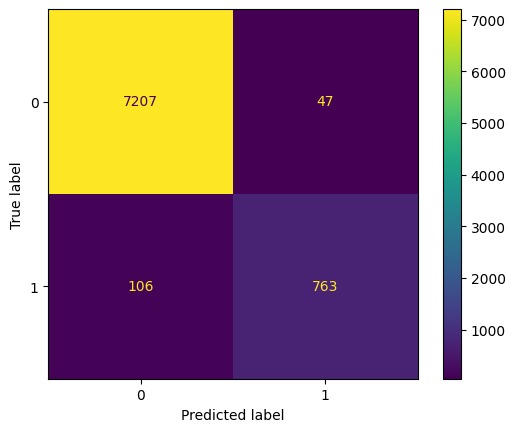

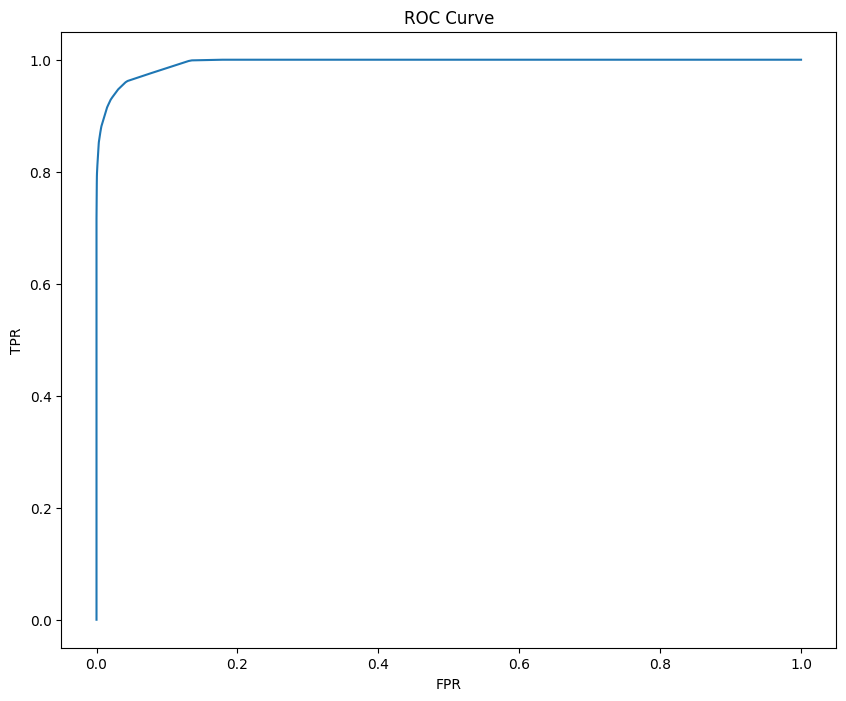

In [140]:
## Evaluation Matrix

# For Training


print('Training Accuracy : ', dt1.score(x_train, y_train))

print('\nClassification Report for Training\n')
print(classification_report(y_train, y_pred_train_dt1))


print('\n F1-Score for Training : ', f1_score(y_train, y_pred_train_dt1))


fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train_dt1)


print('\nAUC Score for Training : ', roc_auc_score(y_train,y_pred_proba_train_dt1))


print('\n\nConfusion Matrix for Training \n')
ConfusionMatrixDisplay.from_estimator(dt1,x_train, y_train)



plt.figure(figsize=(10,8))
plt.plot(fpr_train, tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

Testing Accurayc :  0.9576563269325455

Classification Report for Testing 

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1814
           1       0.81      0.78      0.80       217

    accuracy                           0.96      2031
   macro avg       0.89      0.88      0.89      2031
weighted avg       0.96      0.96      0.96      2031


 F1-Score for Testing :  0.7981220657276995

AUC Score for Testing :  0.9341641304955315


Confusion Matrix for Testing 



Text(0.5, 1.0, 'ROC Curve')

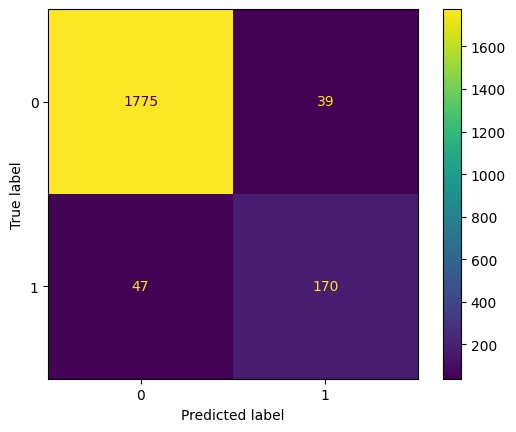

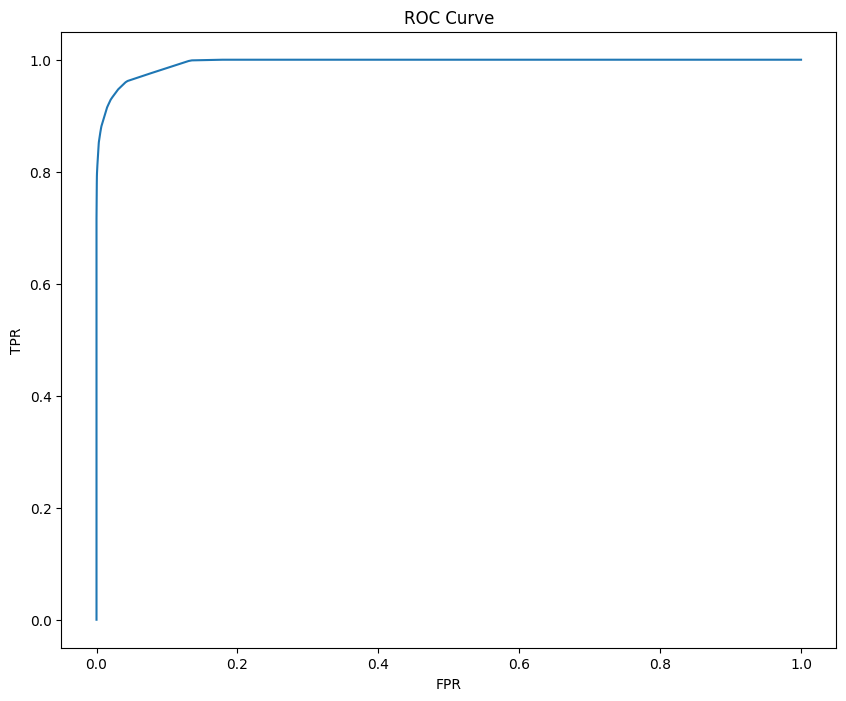

In [141]:
# For Testing


print('Testing Accurayc : ', dt1.score(x_test, y_test))

print('\nClassification Report for Testing \n')
print(classification_report(y_test, y_pred_test_dt1))


print('\n F1-Score for Testing : ', f1_score(y_test, y_pred_test_dt1))


fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test_dt1)


print('\nAUC Score for Testing : ', roc_auc_score(y_test,y_pred_proba_test_dt1))


print('\n\nConfusion Matrix for Testing \n')
ConfusionMatrixDisplay.from_estimator(dt1,x_test, y_test)



plt.figure(figsize=(10,8))
plt.plot(fpr_train, tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')



In [142]:
## So We have Training F1 > 89.63 and Testing F1 > 77.23 , So its an overfit model

In [143]:
## Lets try with Random Forest Clasifier

rf = RandomForestClassifier(random_state=10)

rf.fit(x_train, y_train)

RandomForestClassifier(random_state=10)

In [144]:
y_pred_train_rf = rf.predict(x_train)
y_pred_test_rf = rf.predict(x_test)

y_pred_proba_train_rf = rf.predict_proba(x_train)[:,1]
y_pred_proba_test_rf = rf.predict_proba(x_test)[:,1]

Training Accuracy :  1.0

Classification Report for Training

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7254
           1       1.00      1.00      1.00       869

    accuracy                           1.00      8123
   macro avg       1.00      1.00      1.00      8123
weighted avg       1.00      1.00      1.00      8123


 F1-Score for Training :  1.0

AUC Score for Training :  0.9999999999999999


Confusion Matrix for Training 



Text(0.5, 1.0, 'ROC Curve')

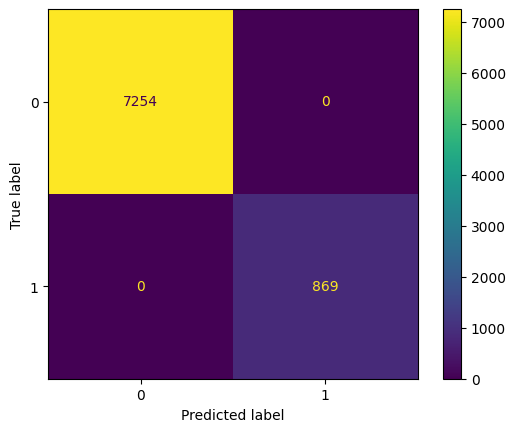

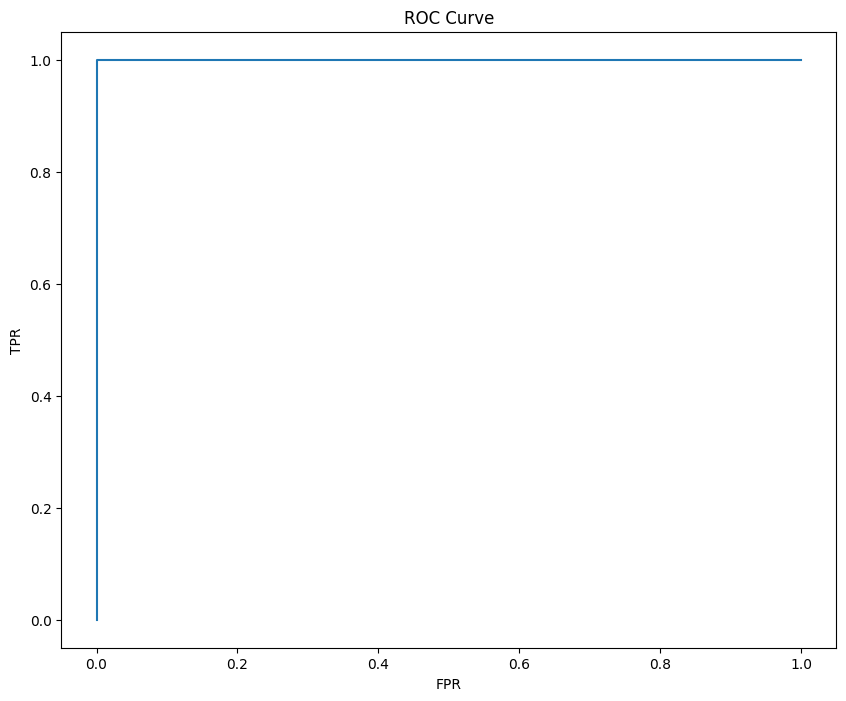

In [145]:
## Evaluation Matrix

# For Training


print('Training Accuracy : ', rf.score(x_train, y_train))

print('\nClassification Report for Training\n')
print(classification_report(y_train, y_pred_train_rf))


print('\n F1-Score for Training : ', f1_score(y_train, y_pred_train_rf))


fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train_rf)


print('\nAUC Score for Training : ', roc_auc_score(y_train,y_pred_proba_train_rf))


print('\n\nConfusion Matrix for Training \n')
ConfusionMatrixDisplay.from_estimator(rf,x_train, y_train)



plt.figure(figsize=(10,8))
plt.plot(fpr_train, tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

Testing Accuracy :  0.9561792220580995

Classification Report for Testing 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1814
           1       0.93      0.64      0.76       217

    accuracy                           0.96      2031
   macro avg       0.94      0.82      0.87      2031
weighted avg       0.96      0.96      0.95      2031


 F1-Score for Testing :  0.7574931880108992

AUC Score for Testing :  0.9862907036414168


Confusion Matrix for Testing 



Text(0.5, 1.0, 'ROC Curve')

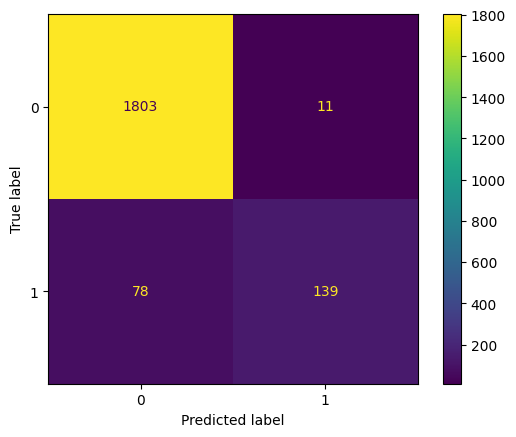

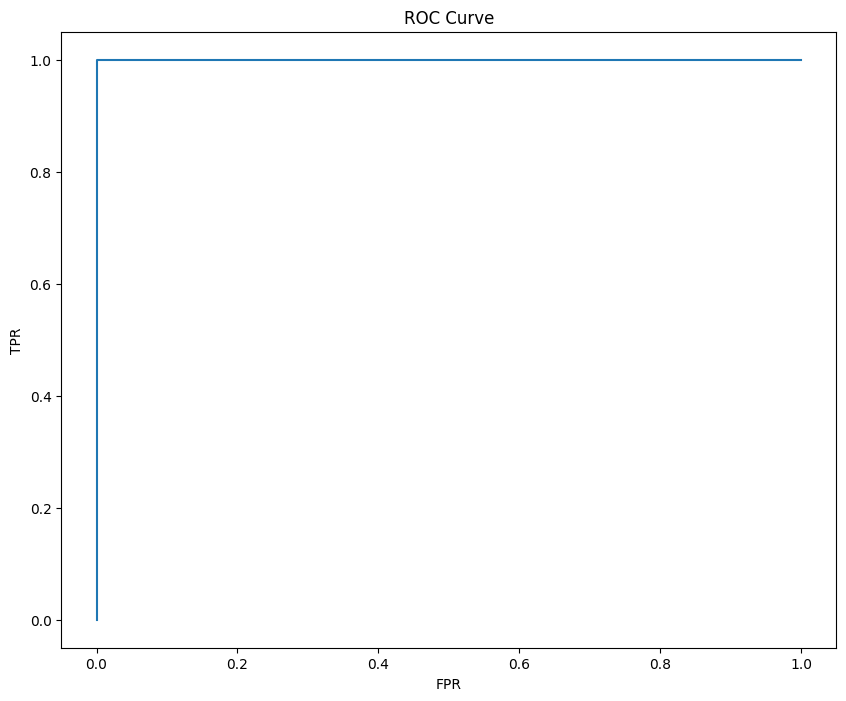

In [146]:
# For Testing


print('Testing Accuracy : ', rf.score(x_test, y_test))

print('\nClassification Report for Testing \n')
print(classification_report(y_test, y_pred_test_rf))


print('\n F1-Score for Testing : ', f1_score(y_test, y_pred_test_rf))


fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test_rf)


print('\nAUC Score for Testing : ', roc_auc_score(y_test,y_pred_proba_test_rf))


print('\n\nConfusion Matrix for Testing \n')
ConfusionMatrixDisplay.from_estimator(rf,x_test, y_test)



plt.figure(figsize=(10,8))
plt.plot(fpr_train, tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')


In [147]:
## So we have F1_Training Score >100 , F1_Testin Score > 75.34
## Its an overfitting model mainly due to class imbalance.
## So We train the random forest on it default values.
## Lets try to tune the HyperParameters

In [150]:
## Random Forest Hyper Tunning

rf1 = RandomForestClassifier(random_state=100)

params1={'n_estimators':[50,100,200], ## No of Tress in the forest
        'class_weight':['balanced', {0: 0.45, 1:0.55}, {0:0.55, 1:0.45},None],
        'criterion':['gini','entropy','log_loss'],
        'max_depth':[5,7,9],
        'bootstrap': [True, False]}

grid_search_rf = GridSearchCV(rf1, param_grid=params1, cv=5, return_train_score=True, scoring='f1',
                              verbose=True, n_jobs=-1)

grid_search_rf.fit(x_train,y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', {0: 0.45, 1: 0.55},
                                          {0: 0.55, 1: 0.45}, None],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 7, 9],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='f1', verbose=True)

In [151]:
## Lets try to look for cv_result_

list(grid_search_rf.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_bootstrap',
 'param_class_weight',
 'param_criterion',
 'param_max_depth',
 'param_n_estimators',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score',
 'split0_train_score',
 'split1_train_score',
 'split2_train_score',
 'split3_train_score',
 'split4_train_score',
 'mean_train_score',
 'std_train_score']

In [152]:
grid_search_rf.best_params_

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 9,
 'n_estimators': 200}

In [153]:
## Lets instantiate the model with these paramerts and check the F1Score for training and testing

rf1 = grid_search_rf.best_estimator_
rf1.fit(x_train,y_train) ## Fitting the Model

y_pred_train_rf1 = rf1.predict(x_train)
y_pred_test_rf1 = rf1.predict(x_test)

y_pred_proba_train_rf1 = rf1.predict_proba(x_train)[:,1]
y_pred_proba_test_rf1 = rf1.predict_proba(x_test)[:,1]

Training Accuracy :  0.9687307644958759

Classification Report for Training

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      7254
           1       0.78      0.98      0.87       869

    accuracy                           0.97      8123
   macro avg       0.89      0.97      0.93      8123
weighted avg       0.97      0.97      0.97      8123


 F1-Score for Training :  0.8701431492842536

AUC Score for Training :  0.9978078044635823


Confusion Matrix for Training 



Text(0.5, 1.0, 'ROC Curve')

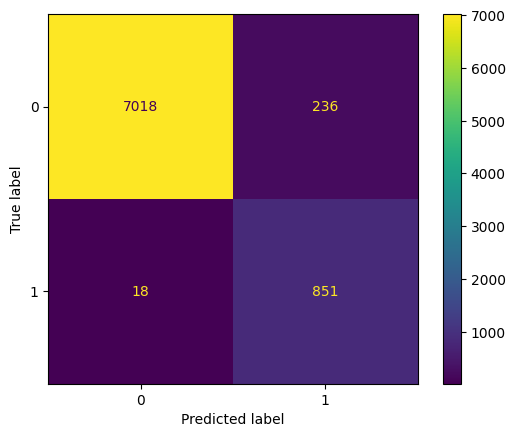

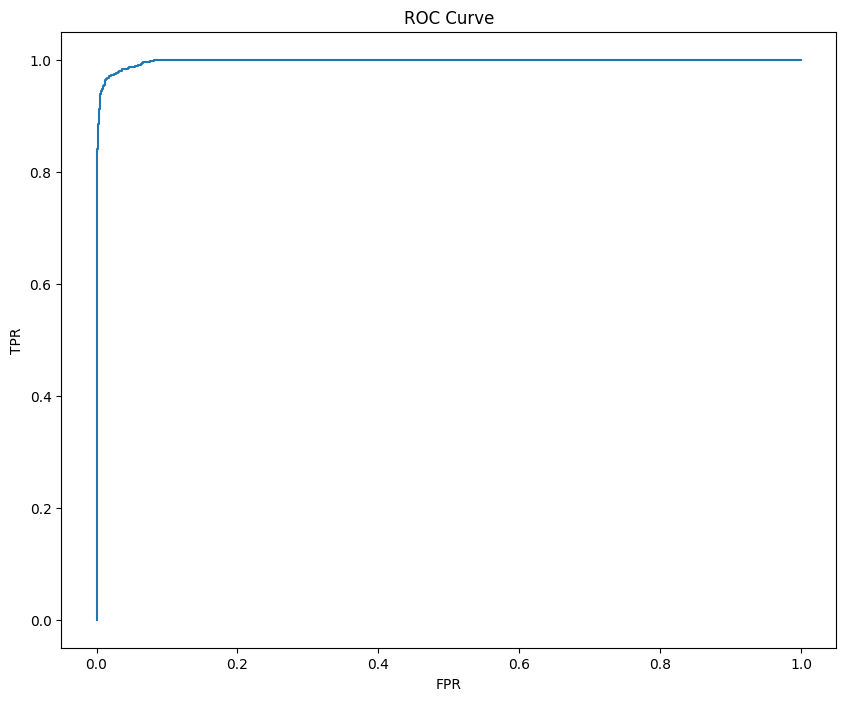

In [154]:
## Evaluation Matrix

# For Training


print('Training Accuracy : ', rf1.score(x_train, y_train))

print('\nClassification Report for Training\n')
print(classification_report(y_train, y_pred_train_rf1))


print('\n F1-Score for Training : ', f1_score(y_train, y_pred_train_rf1))


fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train_rf1)


print('\nAUC Score for Training : ', roc_auc_score(y_train,y_pred_proba_train_rf1))


print('\n\nConfusion Matrix for Training \n')
ConfusionMatrixDisplay.from_estimator(rf1,x_train, y_train)



plt.figure(figsize=(10,8))
plt.plot(fpr_train, tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

Testing Accuracy :  0.947316592811423

Classification Report for Testing 

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1814
           1       0.70      0.89      0.78       217

    accuracy                           0.95      2031
   macro avg       0.84      0.92      0.88      2031
weighted avg       0.96      0.95      0.95      2031


 F1-Score for Testing :  0.7829614604462475

AUC Score for Testing :  0.9807081633378891


Confusion Matrix for Testing 



Text(0.5, 1.0, 'ROC Curve')

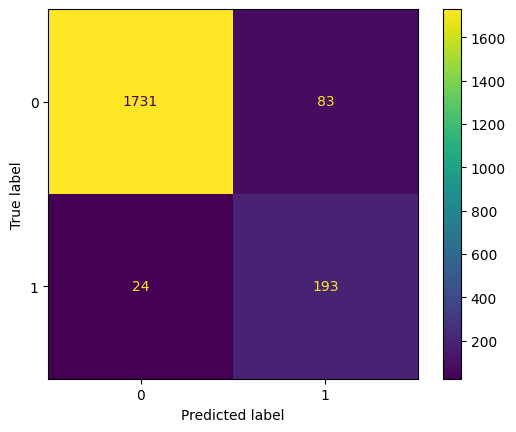

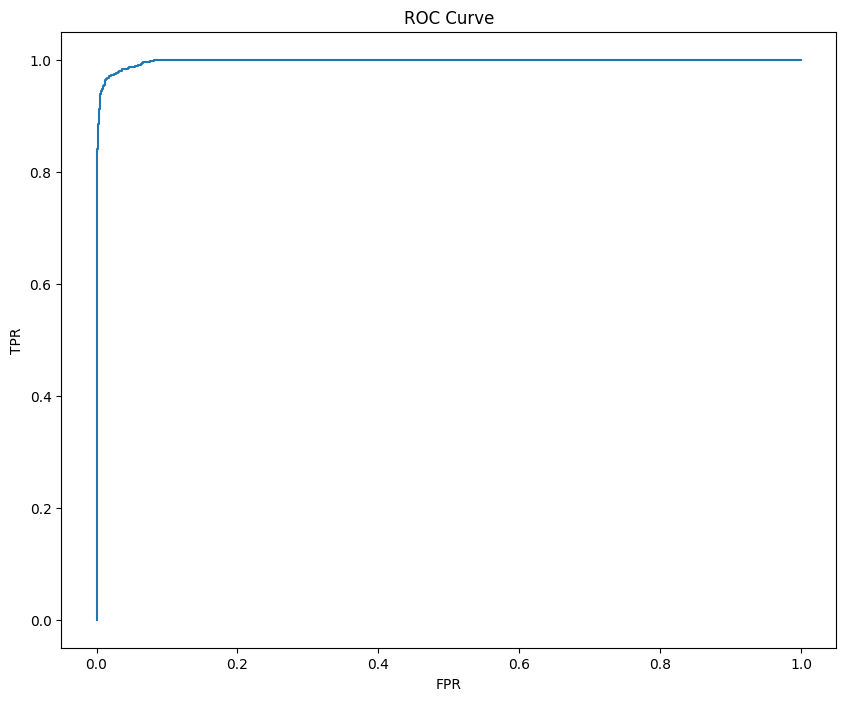

In [155]:
## Evaluation Matrix



print('Testing Accuracy : ', rf1.score(x_test, y_test))

print('\nClassification Report for Testing \n')
print(classification_report(y_test, y_pred_test_rf1))


print('\n F1-Score for Testing : ', f1_score(y_test, y_pred_test_rf1))


fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test_rf1)


print('\nAUC Score for Testing : ', roc_auc_score(y_test,y_pred_proba_test_rf1))


print('\n\nConfusion Matrix for Testing \n')
ConfusionMatrixDisplay.from_estimator(rf1,x_test, y_test)



plt.figure(figsize=(10,8))
plt.plot(fpr_train, tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

In [158]:
## F1-Score for Training > 87.01 and F1-Score for Testing > 78.29
## Which shows the model performance has been improved,
## So our model is ready for deployement.